# Project Title: Multinomial Classification Machine Learning Algorithm Comparison on High-Dimension Leukemia Genomic Data

**Author: Tyler Kinkade**

**Project Repository: [https://github.com/tyknkd/leukemia-classifiers](https://github.com/tyknkd/leukemia-classifiers)**

# Project Topic Overview

There are several different types of leukemia (i.e., blood and bone marrow cancer), including acute lymphocytic leukemia (ALL), acute myeloid leukemia (AML), chronic lymphocytic leukemia (CLL), chronic myeloid leukemia (CML), and myelodysplastic syndrome (MDS). Furthermore, each type's relative prevalence in the general population varies. **Distinguishing these types of leukemia** from one another is complex yet obviously crucial for proper treatment. 

To facilitate differential diagnosis, several supervised machine learning algorithms can potentially be applied. These include the **logistic regression, random forest, adaptive boosting, and support vector machine** algorithms. However, some of these algorithms might perform better than others on **multinomial classification tasks** on imbalanced, high-dimensional genomic datasets. Therefore, the **goal** of this project is to compare the effectiveness of these algorithms in distinguishing five types of leukemia based on imbalanced, highly dimensional genomic data in order to better understand the algorithms' strengths and weaknesses in this context.

# Data

The **publicly-sourced tabular data** comes from a study examining the use of machine learning to diagnose acute myeloid leukemia from blood transcriptome data (**[Warnat-Herresthal et al., 2020](https://doi.org/10.1016/j.isci.2019.100780)**). Warnat-Herresthal and her colleagues sourced the data from the National Center for Biotechnology Information (NCBI, 2024) Gene Expression Omnibus (GEO), which is a public repository of microarray data.

To understand the data and how it is used in this project, it is important to consider four key differences between this project and the original study. First, the study was on binomial classification of only one type of leukemia (AML), but this project is on multinomial classification of several types of leukemia. Second, the researchers used the R programming language in their analysis, but this project uses Python. Third, the study used three different datasets, but this project uses only the first and second datasets because the third dataset uses different measurement methodology. Fourth, the researchers did not adjust the class imbalance to match the population from which it was taken.

The dataset contains **10,848 samples** and **12,717 features.** There are **9 categorical features** and **12,708 numeric features.** There are far too many numeric (real-valued) features to describe each one here, but in general, each one represents the expression of an mRNA gene. For example, `PAX8` refers to the _paired box 8_ gene, and `CCL5` refers to the _C-C motif chemokine ligand 5_ gene (NCBI, 2025). The categorical features are summarized in the following table:

| Categorical Feature   | Description | Unique Values |
| --------- | ----------- | ------------- |
| GSE       | GEO Series  | 64 values (e.g., GSE42038) |
| Filename  | GEO Sample  | 8,348 values (e.g., GSM1030962_10030.CEL) |
| Row.names | Duplicates Filename | Same as Filename above |
| Dataset   | Warnat-Herresthal study dataset | 1, 2, or 3 |
| Condition | Warnat-Herresthal study target | CASE (i.e., AML) or CONTROL (i.e., non-AML) |
| Disease   | Diagnosis | 25 values (e.g., AML, healthy, Dengue fever, etc.) |
| Tissue    | Tissue type sampled | BM, PBMC, or 'BM or PBMC' |
| FAB       | Simplified French-Am.-Brit. AML class | 9 values (e.g., unknown, M0, M1, M2, M3, ..., M7) |
| FAB_all   | All FAB AML classes | 14 values (e.g., unknown, M3, M3v, M4, M4e, etc. ) |

In the context of this project, only the categorical `Disease` feature and the numeric gene features and only the leukemia samples are relevant. The irrelevant features and samples will be removed in the Data Cleaning Section below.

To **import the data,** it was first necessary to download the researchers' Docker image from their public [Docker Hub](https://hub.docker.com/r/schultzelab/aml_classifier), extract the R data from the Docker container, aggregate the transcriptome data and metadata, and export it to a comma-delimited file (CSV). The procedures and code for these preliminary steps are found in the Jupyter notebook `rdata.ipynb` in this project's repository.

The following code cells load the data from the resulting **1.3 GB** CSV and display several columns of the first few rows.

In [1]:
# Load libraries
import gc
import time
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category = UserWarning, module = 'matplotlib')
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.stats.api as sms
import pingouin as pg
from copy import deepcopy
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

In [2]:
# Import data
df = pd.read_csv('data/leukemia.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10848 entries, 0 to 10847
Columns: 12717 entries, Row.names to FAB_all
dtypes: float64(12708), int64(1), object(8)
memory usage: 1.0+ GB


In [3]:
df.head()

,Row.names,PAX8,CCL5,MMP14,DTX2P1-UPK3BP1-PMS2P11,BAD,PRPF8,CAPNS1,RPL35,EIF4G2,...,MIR3648-2,MIR3648-1,Dataset,GSE,Condition,Disease,Tissue,FAB,Filename,FAB_all
0,AHW_ALL_BA_025919_13_A_PZ.CEL,9.221573,7.990144,8.391732,9.280415,5.579486,9.587992,10.143771,11.364570,10.956290,...,6.373859,6.086670,1,Haferlach,CONTROL,ALL,BM or PBMC,unknown,AHW_ALL_BA_025919_13_A_PZ.CEL,unknown
1,AHW_ALL_BA_032751_71_A_PZ.CEL,8.524435,6.648112,8.183514,8.798847,5.934621,10.605028,10.613034,11.664621,11.632159,...,6.572640,7.823704,1,Haferlach,CONTROL,ALL,BM or PBMC,unknown,AHW_ALL_BA_032751_71_A_PZ.CEL,unknown
2,AHW_ALL_BN_022495_7_A_PZ.CEL,8.606060,6.382602,7.909023,8.948909,5.646312,10.367226,9.836321,12.081325,11.690962,...,11.165859,10.734375,1,Haferlach,CONTROL,ALL,BM or PBMC,unknown,AHW_ALL_BN_022495_7_A_PZ.CEL,unknown
3,AHW_ALL_MLL_031351_13_A_PZ.CEL,8.841501,6.469583,8.105744,8.941517,5.899868,10.493261,10.701126,12.029874,11.328697,...,9.551800,9.627878,1,Haferlach,CONTROL,ALL,BM or PBMC,unknown,AHW_ALL_MLL_031351_13_A_PZ.CEL,unknown
4,AHW_ALL_MLL_036187_80_A_PZ.CEL,8.882826,8.332415,7.820992,8.725958,5.651731,10.684440,10.524360,11.856132,11.388613,...,11.295602,10.229529,1,Haferlach,CONTROL,ALL,BM or PBMC,unknown,AHW_ALL_MLL_036187_80_A_PZ.CEL,unknown


# Data Cleaning

This section details the procedures followed to drop features and samples, check for missing values, rebalance the classes, check for extreme values, and scale the data.

## Dropping Features and Samples

As previously explained, only numeric gene features, the categorical `Disease` feature, and the leukemia samples are relevant to this project. After dropping the irrelevant features and samples, the dataset consists of 8,165 samples with 12,708 numeric features and one categorical feature (i.e., the target leukemia classes).

In [4]:
# Drop irrelevant features and samples
irrelevant = ['Row.names', 'Dataset', 'GSE', 'Condition', 'Tissue', 'FAB', 'Filename', 'FAB_all']
leukemias = ['AML', 'ALL', 'CLL', 'CML', 'MDS']
df.drop(irrelevant, axis = 1, inplace = True)
df = df[df.Disease.isin(leukemias)]
df.reset_index(drop = True, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8165 entries, 0 to 8164
Columns: 12709 entries, PAX8 to Disease
dtypes: float64(12708), object(1)
memory usage: 791.7+ MB


## Missing Values

The following code block checks for missing values, including NaNs, zero-coded values, and values coded as several nines. None were found.

In [5]:
# Check for missing values
print('NaNs:', df.isnull().values.any())
print('Zeros:', df.eq(0).any().any())
print('999s:', df.eq(999).any().any())
print('9999s:', df.eq(9999).any().any())

NaNs: False
Zeros: False
999s: False
9999s: False


## Class Balance

It is important to compare the relative balance of classes in the dataset sample relative to the population in order to avoid biased models which would not perform well on unseen data. In addition, understanding the frequency of the classes is important for choosing appropriate performance evaluation metrics and algorithm hyperparameters (Fernández et al., 2018).

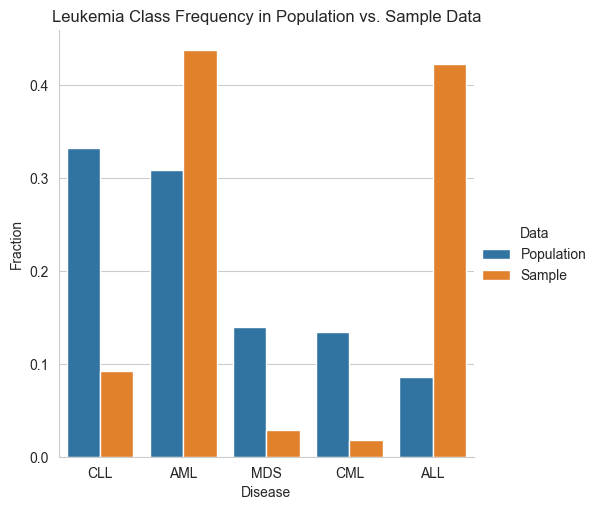

In [6]:
# Check ratio of leukemia classes relative to population with grouped bar chart

def CompareClassPlot(value_counts_1: pd.Series, 
                     value_counts_2: pd.Series, 
                     name_1: str = '1', 
                     name_2: str = '2', 
                     fractions: bool = False) -> sns.FacetGrid:
    '''
    Returns Seaborn bar chart grouped by leukemia class
    '''
    count = 'Count'
    
    if fractions:
        value_counts_1 = value_counts_1 / value_counts_1.sum()
        value_counts_2 = value_counts_2 / value_counts_2.sum()
        count = 'Fraction'

    value_counts_1 = value_counts_1.to_frame().rename(columns = {'count': name_1})
    value_counts_2 = value_counts_2.to_frame().rename(columns = {'count': name_2})

    combined = pd.concat([value_counts_1, value_counts_2], axis = 1)
    longform = combined.stack().to_frame(count).reset_index().rename(columns = {'level_1': 'Data'})

    # Construct plot
    sns.set_style('whitegrid')
    ax = sns.catplot(data = longform, x = 'Disease', 
            y = count, 
            kind = 'bar', 
            hue = 'Data'
            )
    ax.set(title = f'Leukemia Class Frequency in {name_1} vs. {name_2} Data')
    return ax

# Class counts in dataset
sample_counts = df.Disease.value_counts()

# US population leukemia diagnosis estimates from American Cancer Society (2024, 2025a, b, c, d)
acs = {'CLL': 23690, 'AML': 22010, 'MDS': 10000, 'CML': 9560, 'ALL': 6100}
population_counts = pd.Series(acs, name = 'count')
population_counts.index.rename('Disease', inplace = True)

CompareClassPlot(population_counts, sample_counts, 'Population', 'Sample', fractions = True);
plt.savefig('images/class_freq_pop_sample.png', dpi = 300, bbox_inches = 'tight')

 The grouped bar chart above compares the proportion of leukemia classes in this dataset to the American Cancer Society's (ACS, 2024, 2025a, b, c, d) leukemia diagnosis estimates for the US population in 2025. We can see that the classes of leukemia are imbalanced even in the general population of leukemia diagnoses, so it is unrealistic to expect sampled data to be perfectly balanced. However, compared to the population estimates, ALL and AML are overrepresented in this dataset, and CLL, MDS, and CML are underrepresented. Models fit on this data will likely be biased and perform poorly on unseen samples from the population. 
 
 Although methods such as the synthetic minority oversampling technique (SMOTE) do exist, they tend to increase bias toward the oversampled classes and ultimately do not solve the problem of generalization to the population from incomplete information (Provost, 2000; Verzino, 2021). Therefore, undersampling of the overrepresented classes was chosen to achieve a class ratio comparable to the ACS population estimates. 
 
 In addition, it will be important to use performance metrics robust to class imbalance, such as precision, recall, and F1 score when fitting and comparing the models.

In [7]:
# Simple random undersampling of majority classes to achieve population class frequencies

def Undersample(df: pd.DataFrame, target_variable: str, target_frequency: pd.Series) -> pd.DataFrame:
    '''
    Simple random undersampling of majority classes 
    in Pandas dataframe to match target class frequencies
    '''

    # Determine least-represented class 
    target_counts = df[target_variable].value_counts()
    minority_class = target_counts.index[target_counts.argmin()]

    # Calculate resampled total based on minority class target frequency
    resample_total = round(target_counts[minority_class] / target_frequency[minority_class])

    # Resample each class at target frequency
    target_vector = df[target_variable].to_numpy()
    samples_total = len(target_vector)
    resample_indices = np.zeros(samples_total, dtype = bool)
    np.random.seed(31)
    for target_class, fraction in target_frequency.items():
        if target_class == minority_class:
            # Select all minority class samples
            selection = np.where(target_vector == target_class)[0]
            np.put(resample_indices, selection, True)
        else:
            # Undersample all other classes according to target frequencies
            class_size = round(resample_total * fraction)
            candidates = np.where(target_vector == target_class)[0]
            selection = np.random.choice(candidates, size = class_size, replace = False)
            np.put(resample_indices, selection, True)
    
    new_df = df[resample_indices]
    new_df.reset_index(drop = True, inplace = True)
    
    return new_df

# Calculate population class frequencies
population_frequency = population_counts / population_counts.sum()

# Resample data
df = Undersample(df, 'Disease', population_frequency)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1105 entries, 0 to 1104
Columns: 12709 entries, PAX8 to Disease
dtypes: float64(12708), object(1)
memory usage: 107.1+ MB


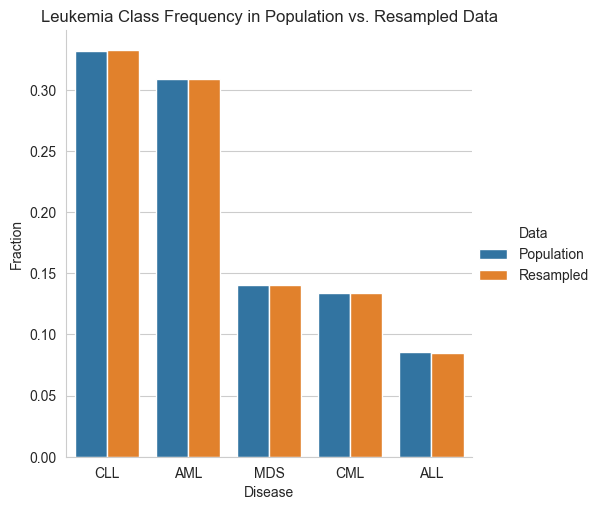

In [8]:
# Compare resampled class ratio to population in bar chart
resample_counts = df.Disease.value_counts()
CompareClassPlot(population_counts, resample_counts, 'Population', 'Resampled', fractions = True);
plt.savefig('images/class_freq_pop_resample.png', dpi = 300, bbox_inches = 'tight')

The above grouped bar chart shows that the class frequency of the 1,105 samples in the resampled data more closely resemble the population. Thus, models trained on the resampled data are more likely to perform better on unseen samples from the population.

## Extreme values

All of the numeric gene expression features are between 2 and 15, so there do not appear to be any extreme values to be concerned about.

In [9]:
# Check for extreme values
print('Grand mean:', round(df.mean(numeric_only = True).mean(), 2))
print('Overall minimum:', round(df.min(numeric_only = True).min(), 2))
print('Overall maximum:', round(df.max(numeric_only = True).max(), 2))

Grand mean: 6.55
Overall minimum: 2.32
Overall maximum: 14.89


## Scaling

Both logistic regression and support vector machines require scaled data, so it is necessary to scale the numeric features.

In [10]:
# Display descriptive statistics before scaling
df.describe()

,PAX8,CCL5,MMP14,DTX2P1-UPK3BP1-PMS2P11,BAD,PRPF8,CAPNS1,RPL35,EIF4G2,EIF3D,...,WNT6,RABEP2,FKBP15,LRCH4,MEX3D,BCAN,ACTB,GAPDH,MIR3648-2,MIR3648-1
count,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,...,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000
mean,7.836282,8.714095,6.554873,8.208145,6.066032,9.641159,10.492725,12.478601,6.382549,10.684078,...,6.708852,7.608334,4.160657,8.228023,4.141601,7.019644,11.448968,12.041669,7.659939,7.275526
std,0.681973,1.839707,0.843577,0.651737,0.591829,0.583903,0.721565,0.816815,2.589399,0.544350,...,1.270418,1.583900,0.640871,1.079568,0.632003,0.479561,1.370045,1.110171,2.412073,1.855900
min,6.620670,3.558120,5.225550,7.076500,4.262340,6.296630,5.827210,8.782517,3.153510,8.118290,...,4.943960,3.986300,2.801630,6.058010,3.007550,5.763920,5.062170,5.877580,3.802480,3.181240
25%,7.322940,7.601577,5.955260,7.732650,5.708720,9.243030,10.156500,12.072082,4.822720,10.406200,...,5.819570,6.388430,3.772630,7.526840,3.677410,6.667880,10.553100,11.298363,5.745480,5.857030
50%,7.624060,8.936300,6.199530,8.011560,6.114580,9.655990,10.583200,12.785800,5.197140,10.781429,...,6.131680,7.387970,4.065430,7.910840,3.939150,6.876170,11.510500,12.302800,7.188510,7.173118
75%,8.342420,10.099200,7.020580,8.611290,6.449581,10.076900,10.939200,13.054800,5.895810,11.059300,...,7.265110,8.973660,4.387719,8.483170,4.611250,7.362825,12.495400,12.933400,8.961060,8.508090
max,10.061842,13.242100,9.195364,10.095035,8.191950,11.249164,12.295036,13.570100,12.383483,12.050600,...,10.302963,11.202900,7.479606,11.391120,6.721280,8.432106,14.165464,13.753100,14.294100,12.721400


In [11]:
# Normalize numeric features
df.iloc[:,:-1] = df.iloc[:,:-1].apply(lambda x: (x - x.mean()) / x.std(), axis = 0)
df.describe()

,PAX8,CCL5,MMP14,DTX2P1-UPK3BP1-PMS2P11,BAD,PRPF8,CAPNS1,RPL35,EIF4G2,EIF3D,...,WNT6,RABEP2,FKBP15,LRCH4,MEX3D,BCAN,ACTB,GAPDH,MIR3648-2,MIR3648-1
count,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1105.000000,1.105000e+03,...,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03
mean,1.028840e-16,-2.314890e-16,7.201881e-16,-2.212006e-15,2.572100e-17,-1.208887e-15,-1.015980e-15,2.057680e-16,0.000000,2.166995e-15,...,-3.086520e-16,5.079898e-16,-4.115361e-16,-8.230721e-16,-7.716301e-17,7.716301e-17,4.243966e-16,-1.929075e-17,4.501176e-16,4.243966e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.782493e+00,-2.802606e+00,-1.575816e+00,-1.736351e+00,-3.047658e+00,-5.727886e+00,-6.465826e+00,-4.524996e+00,-1.247022,-4.713486e+00,...,-1.389221e+00,-2.286783e+00,-2.120592e+00,-2.010075e+00,-1.794376e+00,-2.618485e+00,-4.661742e+00,-5.552375e+00,-1.599230e+00,-2.206092e+00
25%,-7.527307e-01,-6.047260e-01,-7.107973e-01,-7.295803e-01,-6.037421e-01,-6.818405e-01,-4.659668e-01,-4.976884e-01,-0.602390,-5.104764e-01,...,-6.999918e-01,-7.701905e-01,-6.054675e-01,-6.495032e-01,-7.344759e-01,-7.335127e-01,-6.538968e-01,-6.695411e-01,-7.936985e-01,-7.643173e-01
50%,-3.111880e-01,1.207826e-01,-4.212329e-01,-3.016317e-01,8.203036e-02,2.540058e-02,1.253865e-01,3.760939e-01,-0.457793,1.788385e-01,...,-4.543168e-01,-1.391278e-01,-1.485895e-01,-2.938054e-01,-3.203325e-01,-2.991784e-01,4.491215e-02,2.352171e-01,-1.954455e-01,-5.517993e-02
75%,7.421681e-01,7.528940e-01,5.520626e-01,6.185705e-01,6.480741e-01,7.462569e-01,6.187583e-01,7.054219e-01,-0.187974,6.893022e-01,...,4.378538e-01,8.620026e-01,3.543021e-01,2.363418e-01,7.431115e-01,7.156141e-01,7.637934e-01,8.032375e-01,5.394202e-01,6.641329e-01
max,3.263416e+00,2.461263e+00,3.130111e+00,2.895172e+00,3.592116e+00,2.753893e+00,2.497779e+00,1.336287e+00,2.317500,2.510372e+00,...,2.829076e+00,2.269440e+00,5.178807e+00,2.929966e+00,4.081749e+00,2.945319e+00,1.982778e+00,1.541592e+00,2.750398e+00,2.934358e+00


In [12]:
# Check overall mean, minimum, and maximum
print('Grand mean:', round(df.mean(numeric_only = True).mean(), 2))
print('Overall minimum:', round(df.min(numeric_only = True).min(), 2))
print('Overall maximum:', round(df.max(numeric_only = True).max(), 2))

Grand mean: 0.0
Overall minimum: -11.08
Overall maximum: 14.03


In [13]:
# Delete unnecessary objects to free memory
del acs, irrelevant, leukemias, population_counts, resample_counts, sample_counts
c = gc.collect()

## Data Cleaning Summary

After removing irrelevant samples and features, the data was found to be free of missing values. The ratio of leukemia classes did not match the estimated population ratios, so the data was resampled using simple undersampling to better approximate the population. No unusually extreme measurements were found. Then, the numeric features were normalized. Because the dataset (and population) classes are imbalanced, it will be important to use robust performance metrics such as precision, recall, and F1 score when fitting and evaluating models. In addition, care will also need to be taken when splitting the data into training and test sets to maintain representive class ratios through stratification techniques.

# Exploratory Data Analysis

Exploring and visualizing high-dimension data is challenging due to both physical and human limitations (Munzner, 2015). A $12,708\times12,708$ correlation heatmap with each cell represented by a single pixel will simply not display (in full) on a high resolution $3840\times2160\,(4K)$ pixel computer monitor. Even if it were possible to display, it would still be extremely difficult for most humans to meaningfully interpret such a massive and intricately detailed visualization. Therefore, in this section, I visually explore subsets of the data, check for collinearity numerically, and then attempt visualization through a dimension reduction method.

## Scatterplot Matrix and Kernel Density Estimates

Although it is impossible to visualize all 12,709 features (as explained above), it is still possible to look at subsets. In the scatterplot matrix of the data for five arbitrarily selected genes displayed below, the leukemia disease class is depicted by hue. We can see that for every pair of genes, there are different clustering patterns for each type of leukemia. These different patterns are a promising sign, as it indicates that at least these six genes will be useful in differentiating between classes of leukemia. In addition, there is a strong correlation between the microRNA `MIR3648-1` and `MIR3648-2` genes, whose names obviously indicate a strong genetic relationship. The `ACTB` and `GAPDH` genes also appear correlated. Such correlations are to be expected in high-dimensional genomic data. Furthermore, even in the correlated features, there still appears to be clustering by disease class.

On the diagonal, kernel density estimate (KDE) plots of the class distributions for each gene are displayed. We can see that the distributions for each disease class differ by gene and have varying degrees of normality. In accordance with the central theorem, the distributions of the classes with large sample sizes (CLL and AML) appear more normal than the minority classes. However, normality is not a requisite for any of the algorithms being considered in this project.

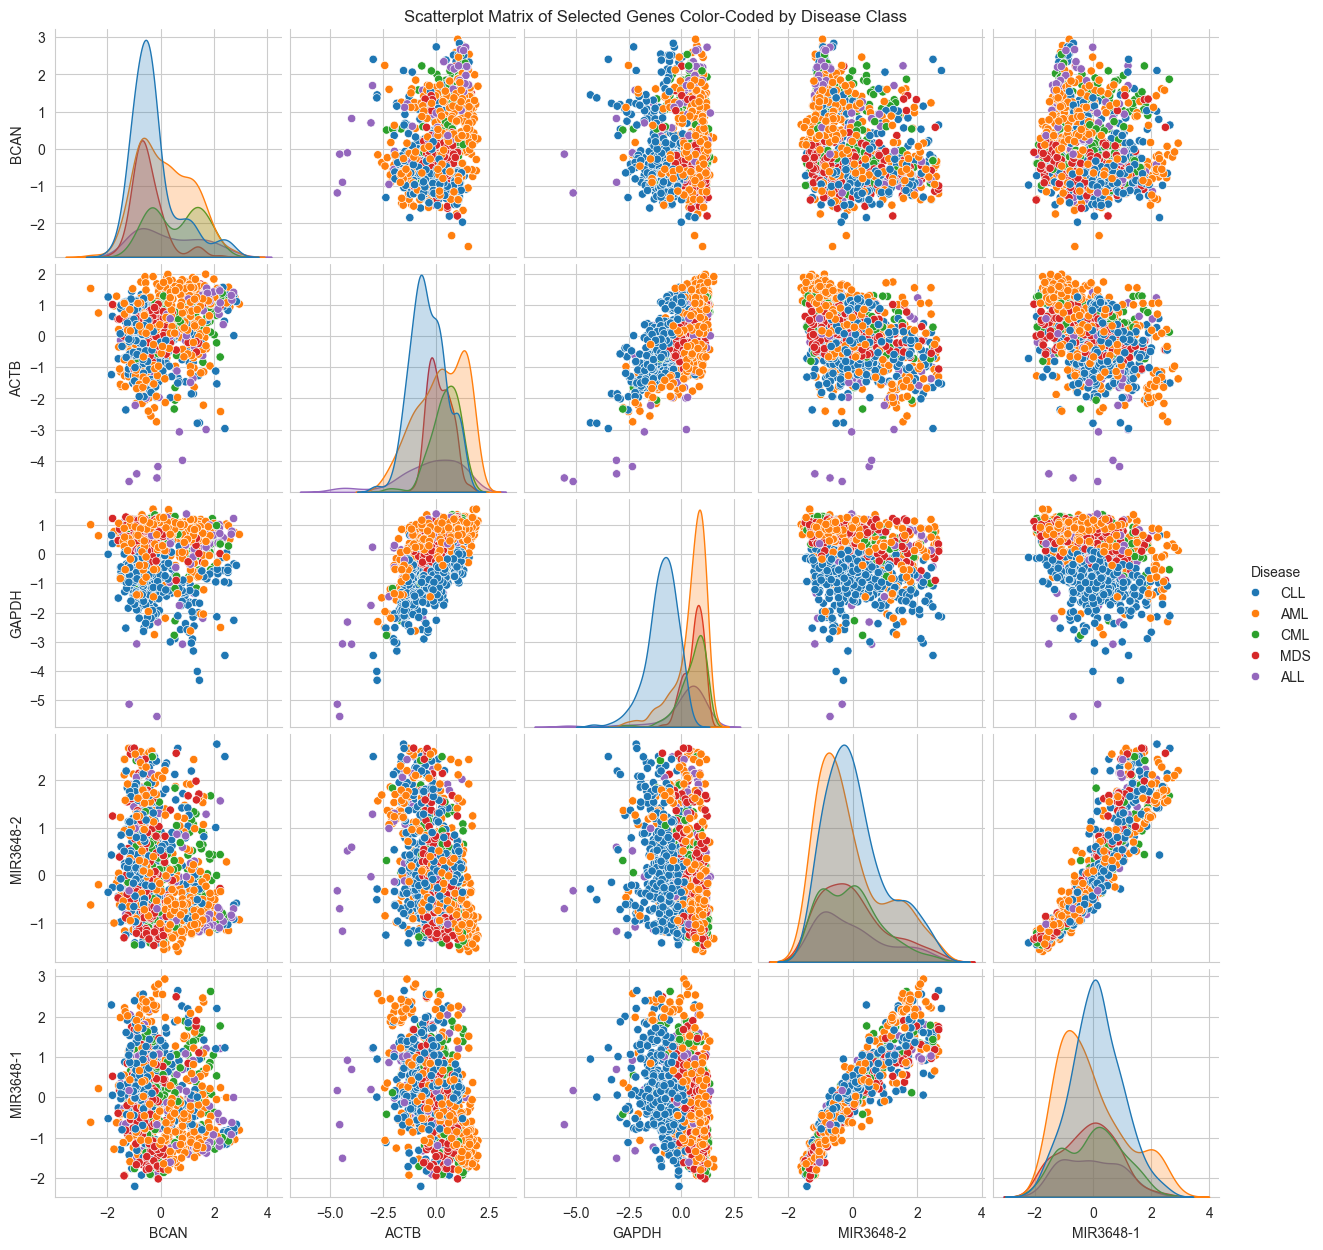

In [14]:
# Scatterplot matrix of last 6 genes with disease class as hue
ax = sns.pairplot(df.iloc[:,-6:], hue = 'Disease')
ax.figure.suptitle('Scatterplot Matrix of Selected Genes Color-Coded by Disease Class', y = 1);
plt.savefig('images/gene_splom.png', dpi = 300, bbox_inches = 'tight')

## Correlation Matrix

The correlation heatmap below displays the correlation of 15 other arbitrarily selected genes from the data. Some of the genes have correlation coefficients above 0.7, such as the ribosomal protein genes `RPL21`, `RPL24`, `RPL35`, and `RPS27AP16`. As their names indicate, these genes are related and should be expected to correlate. These four genes are also negatively correlated with the eukaryotic translation initiation factor `EIF4G2` gene. Such strong correlations suggest collinearity of the features (James et al., 2021).

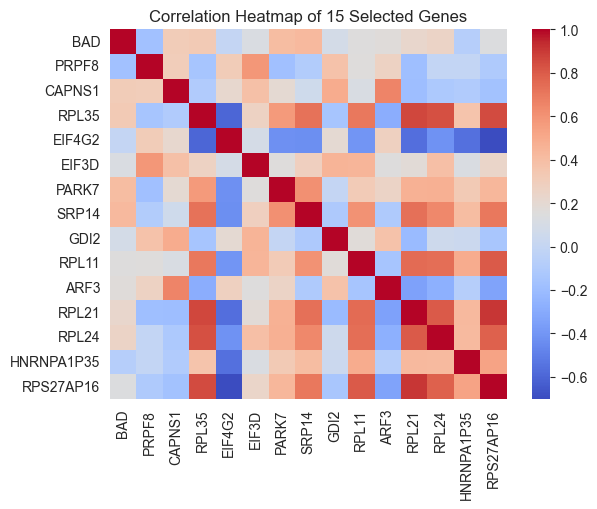

In [15]:
# Correlation heatmap
corr = df.iloc[:,4:19].corr()
sns.heatmap(corr, cmap = 'coolwarm').set(title = 'Correlation Heatmap of 15 Selected Genes');
plt.savefig('images/gene_corr_heatmap.png', dpi = 300, bbox_inches = 'tight')

## Collinearity

Absolute correlation coefficients greater than 0.7 generally indicate levels of collinearity which negatively impact generalized linear models (Dormann et al., 2013). By this criterion, 72% of the numeric features are collinear, based on the calculations below. The highest absolute correlation coefficient is $\rho =0.99$ for the `RPS15` and `RPS19` features.

In [16]:
# Check for high correlation coefficients between all numeric features

def CorrelationMatrix(X: pd.DataFrame) -> np.ndarray:
    '''
    Returns correlation matrix
    '''
    return np.corrcoef(X.T.to_numpy())

def CollinearFeatureCount(X: pd.DataFrame, threshold: float, verbose: bool = False) -> np.int_:
    '''
    Returns count of features above correlation threshold
    Optionally print counta and maximum absolute correlation coefficient and corresponding feature names
    '''
    # Upper triangular correlation matrix excluding diagonal
    corr = np.absolute(CorrelationMatrix(X))
    mask = np.tril(np.ones(corr.shape, dtype = bool))
    corr_masked = np.ma.MaskedArray(corr, mask)

    # Determine total number of features with at least one coefficient above threshold
    collinear_rows = np.any(corr_masked > threshold, axis = 1)
    collinear_cols = np.any(corr_masked > threshold, axis = 0)
    coll_feat_count = (collinear_rows | collinear_cols).data.sum()
    if verbose:
        feat_count = corr.shape[0]
        print(f'Features with abs. corr. coef. |r_ij| > {threshold}: {coll_feat_count:,} ({coll_feat_count / feat_count * 100:.0f}%, i != j)')

        # Get maximum absolute correlation coefficient and corresponding features (excluding diagonal)
        max_idx = np.unravel_index(np.argmax(corr_masked), corr_masked.shape)
        print(f'Max. abs. corr. coef.: {corr[max_idx]:.3f} ({X.columns[max_idx[0]]} vs. {X.columns[max_idx[1]]})')
    
    return coll_feat_count

CollinearFeatureCount(df.iloc[:,:-1], 0.7, True)

Features with abs. corr. coef. |r_ij| > 0.7: 9,170 (72%, i != j)
Max. abs. corr. coef.: 0.990 (RPS15 vs. RPS19)


np.int64(9170)

To detect multicollinearity, a variance inflation factor (VIF) greater than 5 or 10 is frequently used as a criterion (James et al., 2021). The VIFs of all features are often calculated by iteratively fitting linear regression models with the target feature predicted by the rest. This is computationally expensive and unscalable for high-dimension data. Fortunately, VIFs are also the diagonal of the inverse correlation matrix (Ferré, 2009), which is less computationally expensive to calculate.

Based on the calculations below, about 34% of the features have VIFs greater than 5 and 27% have VIFs greater than 10. The `SERPINA6` feature has the highest VIF of 7,412. Clearly, there is multicollinearity in the numeric features. Therefore, regularization or dimension reduction could be helpful in improving model performance in the main analysis.

In [17]:
# Calculate VIFs
def CalculateVIFs(X: pd.DataFrame) -> np.ndarray:
    '''
    Return array of VIFs
    '''
    # VIFs are diagonal of inverse correlation matrix (Ferre, 2009)
    corr_inv = np.linalg.inv(np.absolute(CorrelationMatrix(X)))
    
    return corr_inv.diagonal()


def MulticollinearFeatureCount(vifs: np.ndarray, threshold: int, verbose: bool = False) -> np.int_:
    '''
    Return (and optionally print) count of VIFs above threshold
    '''
    # Count variance inflation factors above threshold
    multicollinear = vifs > threshold
    multi_count = multicollinear.sum()
    if verbose:
        feat_count = len(vifs)
        print(f'Features with VIF > {threshold}: {multi_count:,} ({multi_count / feat_count * 100:.0f}%)')
    
    return multi_count

vifs = CalculateVIFs(df.iloc[:,:-1])
MulticollinearFeatureCount(vifs, 5, True)
MulticollinearFeatureCount(vifs, 10, True)

# Print 10 features with highest VIF
vifs = pd.Series(vifs, index = df.iloc[:,:-1].columns, name = 'VIF')
vifs.sort_values(ascending = False, inplace = True)
vifs.round().head(10)

Features with VIF > 5: 4,363 (34%)
Features with VIF > 10: 3,489 (27%)


SERPINA6    7412.0
EN2         6816.0
TDGF1P3     5894.0
ADH6        5207.0
DCSTAMP     4532.0
GFRA4       4328.0
NPY4R       4240.0
THBS2       4161.0
TSHB        4127.0
EFHD1       4097.0
Name: VIF, dtype: float64

In [18]:
# Delete unnecessary objects to free memory
del corr, vifs
c = gc.collect()

## T-Distributed Stochastic Neighbor Embedding

T-distributed stochastic neighbor embedding (t-SNE, van der Maaten & Hinton, 2008) is a method for visualizing the structure of highly dimensional data in lower dimensions. Unlike principal components analysis (PCA), it can be used with both linear and non-linear data, and it preserves the relationships between data points. 

Iterations run: 999
Kullback-Leibler divergence: 0.714


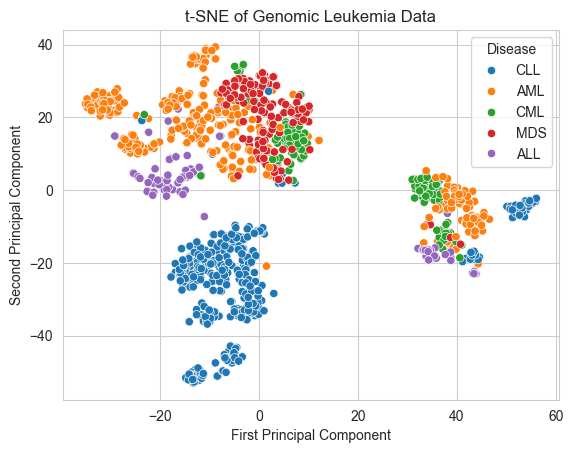

In [19]:
# Visualize data with t-SNE
tsne = TSNE(n_components = 2, perplexity = 30, random_state = 31)
X_tsne = tsne.fit_transform(X = df.iloc[:,:-1])

print('Iterations run:', tsne.n_iter_)
print('Kullback-Leibler divergence:', round(tsne.kl_divergence_, 3))

# Plot
ax = sns.scatterplot(x = X_tsne[:,0], y = X_tsne[:,1], hue = df.Disease)
ax.set(title = 't-SNE of Genomic Leukemia Data',
       xlabel = 'First Principal Component',
       ylabel = 'Second Principal Component');
plt.savefig('images/gene_tsne.png', dpi = 300, bbox_inches = 'tight')

In the t-SNE plot above, we can see three macroclusters, each composed of smaller microclusters. One of the macroclusters is almost entirely genomic data classified as CLL, the majority class. The other two macroclusters are more mixed, but even within these we can see some separation. For example, in the largest macrocluster near the top, the data classified as ALL is mostly separated from the other classes and there are several sub-clusters of AML. Thus, it appears there are some patterns in the genomic data that differentiate the classes.

## EDA Summary

The large number of features makes visualizing all the paired relationships in the data infeasible. However, paired scatterplots and correlation heatmaps of subsets of the data revealed some strong relationships between some of the features, which suggests collinearity. This was also supported by numerical calculations that indicated collinearity and multicollinearity. Regularization or dimension reduction should be used to mitigate its impact in the main analysis. Kernel distribution estimate plots also showed differences in the class distributions for various genes with varying degrees of normality. Finally, a t-SNE plot of the data revealed good separation of the majority class from the others, but less so between the other classes. This may be in part due to the smaller sample sizes of the minority classes. Oversampling methods, such as SMOTE, might be useful in overcoming issues of sample size, but they also tend to result in biased models that do not perform well on unseen data.

# Models 

In this section, **multiple machine learning models** are fit with **grid-search cross-validation hyperparameter tuning** on a training subset with weighted scoring to manage **imbalance**. **Multiple performance metrics** and **feature importance** are examined for each model.

## Train-Test Split

In order to compare the models' performance, the data is separated into an 80:20 training-test split with the same class frequencies. (As explained in the Data Cleaning Section above, the data was intentionally **undersampled** to achieve a class frequency similar to the population.)

Training set: 884 samples (80.0%)
Test set: 221 samples (20.0%)


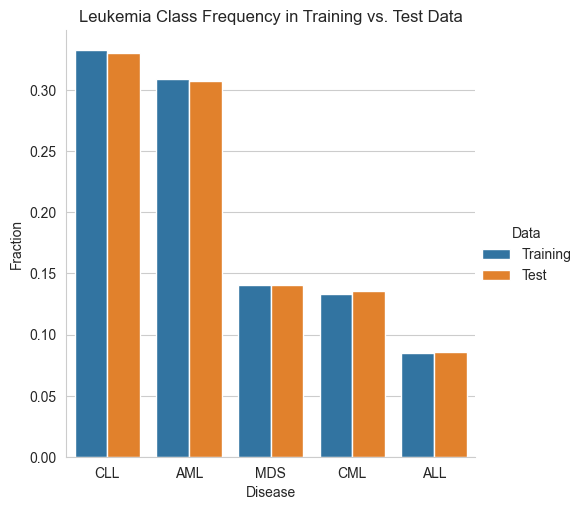

In [20]:
# 80:20 train-test split with equal class frequencies
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.Disease, test_size = 0.20, random_state = 31, shuffle = True, stratify = df.Disease)

train_length = len(y_train.index)
test_length = len(y_test.index)
samples_total = len(df.index)

print(f'Training set: {train_length} samples ({round(train_length / samples_total * 100, 1)}%)')
print(f'Test set: {test_length} samples ({round(test_length / samples_total * 100, 1)}%)')

CompareClassPlot(y_train.value_counts(), y_test.value_counts(), 'Training', 'Test', fractions = True);
plt.savefig('images/class_freq_train_test.png', dpi = 300, bbox_inches = 'tight')

The grouped bar chart above shows that the training and test datasets have almost identical class frequencies.

In [21]:
# Delete unnecessary objects to free memory
del ax, df, tsne, X_tsne
c = gc.collect()

## Dimension Reduction

As previously discussed, (multi)collinearity can adversely affect generalized linear models, so when detected, dimension reduction is generally recommended. However, the aim of this project is to compare how the models perform on high-dimension data. Thus, models trained on high-dimension data will be compared with models trained on lower-dimension data.

It is often recommended to iteratively remove features with high VIFs; however, this has time complexity quartic in the number of dimensions, and therefore, is infeasible for high-dimension data. PCA is another alternative, but complicates model interpretability. A more interpretable and feasible option is to reduce pairwise correlation by removing highly correlated features (Kuhn, 2008).

In [22]:
# Identify correlated features that can be dropped to reduce collinearity

def CollinearFeatures(X: pd.DataFrame, threshold: float) -> pd.Index:
    '''
    Return Pandas index of the features with absolute correlation coefficients
    above threshold which have the highest pairwise mean absolute correlation
    coefficients

    Based on R caret package findCorrelation function (Kuhn, 2008)
    '''    
    # Absolute correlation coefficient matrix
    corr = np.absolute(np.corrcoef(X.T.to_numpy()))

    # Feature mean absolute correlation
    corr_mean = corr.mean(axis = 0)

    # Upper triangular correlation matrix excluding diagonal
    mask = np.tril(np.ones(corr.shape, dtype = bool))
    corr_masked = np.ma.MaskedArray(corr, mask)
    
    # Pairwise indices of correlations above threshold
    pair_idxs = np.transpose((corr_masked > threshold).nonzero())
    
    # Separate indices
    row_idxs = pair_idxs[:, 0]
    col_idxs = pair_idxs[:, 1]
    
    # Select feature with greatest mean correlation
    select_col = corr_mean[col_idxs] > corr_mean[row_idxs]
    selected_cols = col_idxs[select_col]
    selected_rows = row_idxs[~select_col]

    # Aggregate indices and remove duplicates
    selected_idxs = np.unique(np.concatenate([selected_cols, selected_rows]))

    # Corresponding Pandas feature indices
    selected_feats = X.columns[selected_idxs]

    return selected_feats

# Select collinear features to drop
threshold = 0.7
drop_features = CollinearFeatures(X_train, threshold)
drop_features

Index(['PAX8', 'CCL5', 'MMP14', 'DTX2P1-UPK3BP1-PMS2P11', 'CAPNS1', 'RPL35',
       'EIF4G2', 'PARK7', 'SRP14', 'GDI2',
       ...
       'FAM86DP', 'SNHG17', 'WNT6', 'RABEP2', 'LRCH4', 'MEX3D', 'BCAN', 'ACTB',
       'GAPDH', 'MIR3648-2'],
      dtype='object', length=7631)

In [23]:
# Create reduced dimension training and test datasets
X_train_reduced = X_train.drop(drop_features, axis = 1)
X_test_reduced = X_test.drop(drop_features, axis = 1)
print('Reduced features training set dimensions:', X_train_reduced.shape)
print('Reduced features test set dimensions:', X_test_reduced.shape)

Reduced features training set dimensions: (884, 5077)
Reduced features test set dimensions: (221, 5077)


In [24]:
# Check for (multi)collinearity in reduced dimension training set
CollinearFeatureCount(X_train_reduced, threshold, True)

vifs = CalculateVIFs(X_train_reduced)
MulticollinearFeatureCount(vifs, 5, True)
MulticollinearFeatureCount(vifs, 10, True)

# Print 10 features with highest VIF
vifs = pd.Series(vifs, index = X_train_reduced.columns, name = 'VIF')
vifs.sort_values(ascending = False, inplace = True)
vifs.round(1).head(10)

Features with abs. corr. coef. |r_ij| > 0.7: 0 (0%, i != j)
Max. abs. corr. coef.: 0.700 (TOM1L1 vs. RAB38)
Features with VIF > 5: 2 (0%)
Features with VIF > 10: 0 (0%)


SUGCT       5.2
ZNF334      5.0
CTNNA1P1    4.5
KCNMB3      4.5
ANKS1B      4.4
ASLP1       4.2
NTN1        4.1
FBLN2       4.0
GJB3        3.8
FAM83E      3.7
Name: VIF, dtype: float64

After dropping the highly-correlated features, there are no features with correlations above 0.7, suggesting no levels of problematic collinearity in the reduced dimension training dataset. Furthermore, there are only two features with VIF above 5. 

To remove the possiblity of multicollinearity above this lower threshold, the feature with the highest VIF is also dropped. As shown below, this lowers the VIF of all remaining features below 5, which indicates that no levels of problematic multicollinearity remain in the reduced dimension training dataset.

In [25]:
# Drop feature with highest VIF
drop_feature = vifs[vifs > 5.1].index
X_train_reduced.drop(drop_feature, axis = 1, inplace = True)
X_test_reduced.drop(drop_feature, axis = 1, inplace = True)
print('Reduced features training set dimensions:', X_train_reduced.shape)
print('Reduced features test set dimensions:', X_test_reduced.shape)

# Update drop features index
drop_features = drop_features.union(drop_feature)

# Check for multicollinearity
vifs = CalculateVIFs(X_train_reduced)
MulticollinearFeatureCount(vifs, 5, True)

# Print 10 features with highest VIF
vifs = pd.Series(vifs, index = X_train_reduced.columns, name = 'VIF')
vifs.sort_values(ascending = False, inplace = True)
vifs.round(1).head(10)

Reduced features training set dimensions: (884, 5076)
Reduced features test set dimensions: (221, 5076)
Features with VIF > 5: 0 (0%)


CTNNA1P1      4.0
ZNF334        3.2
ADAM23        3.1
PAGE4         3.1
NTN1          3.0
RBM12B-AS1    2.9
HS3ST3A1      2.8
KCNMB3        2.8
ZFR2          2.8
GBX2          2.7
Name: VIF, dtype: float64

In [26]:
# Delete unnecessary objects to free memory
del vifs
c = gc.collect()

## Hyperparameter Tuning with Grid-Search Cross-Validation

For each model, grid search with stratified three-fold cross-validation on the training data is used to tune the hyperparameters and achieve a reasonable balance between model bias and variance. Stratified cross-validation ensures that the splits of each fold have the same class frequencies. In addition, class weights inversely proportional to their population frequency are included in the models to **manage data imbalance.** 

Because of the critical nature of cancer differentiation as well as the class imbalance in the population, the weighted F1 score is used as the cross-validation metric, instead of accuracy. F1 score is the harmonic mean of precision and recall and is considered more robust on imbalanced data. The weighted F1 score is the weighted average of the F1 scores for each class. For the sake of comparison, balanced accuracy scores are also reported. Balanced accuracy is the sum of each class' accuracy multiplied by weights inversely proportional to the class' frequencies.

In [27]:
# Grid-search cross-validation settings
def GridSearchCrossValidation(X: pd.DataFrame, y: pd.Series, estimator, param_grid: dict) -> GridSearchCV:
    '''
    GridSearchCV wrapper
    Returns Sci-Kit Learn GridSearchCV object fit to best parameters 
    '''
    clf = GridSearchCV(estimator, param_grid = param_grid, scoring = ['f1_weighted', 'balanced_accuracy'], refit = 'f1_weighted', cv = 3, verbose = 0)
    clf.fit(X, y)
    print('Best parameters:', clf.best_params_)
    print('Best mean CV weighted F1 score:', round(clf.best_score_, 3))
    return clf

# Visualize scoring metrics for each model
def CVScoresPlot(models: dict, model_name: str, feature_set: str, target_param: str = None, target_value = None) -> sns.FacetGrid:
    '''
    Plot a model's cross-validation weighted F1 and balanced accuracy test scores 
    for selected parameter
    '''
    # Make Pandas dataframe of relevant results
    cv_results = models[model_name][feature_set].cv_results_
    params = pd.DataFrame(cv_results['params'])
    scores = pd.DataFrame([pd.Series(cv_results['mean_test_f1_weighted'], name = 'Weighted F1'), 
                           pd.Series(cv_results['mean_test_balanced_accuracy'], name = 'Balanced Accuracy')]).T
    df = pd.concat([params, scores], axis = 1)

    # Set plot labels for single hyperparameter
    x_axis_label = params.columns[0]
    title = f'{model_name} {feature_set} Model Cross-Validation Test Scores'
    
    # If more than one hyperparameter
    if params.shape[1] > 1:
        # Select values for second parameter
        df = df[df[target_param] == target_value]

        # Adjust labels
        x_axis_label = params.columns[params.columns != target_param][0]
        title += f' ({target_param} = {target_value})'
    
    # Convert to long form
    df = pd.melt(df, id_vars= params.columns, value_vars = scores.columns, var_name = 'Metric', value_name = 'Score')
    
    # Plot
    sns.set_style('whitegrid')
    ax = sns.lineplot(df, x = x_axis_label, y = 'Score', hue = 'Metric')
    ax.set_xticks(df[x_axis_label])  # only mark x ticks where measured
    ax.set(title = title)
    return ax

# Dict to store models
models = {} 

# Dict keys
log_reg_key = 'Logistic Regression'
rnd_fst_key = 'Random Forest'
ada_bst_key = 'Adaptive Boosting'
svm_key = 'Support Vector Machine'
full_feat_key = 'Full'
reduce_feat_key = 'Reduced'

### Logistic Regression Model

The L2 (Ridge) inverse regularization strength hyperparameter $C = 0.01$ results in the best grid-search three-fold cross-validation score for the logistic regression model trained on all features. $C = 0.1$ is best for the model trained on the reduced feature set. This is most likely because less regularization is needed when there is less multicollinearity in the data.

In [28]:
# Logistic regression full model training and hyperparameter tuning
param_grid = {'C': [0.001, 0.01, 0.1]}
lr = LogisticRegression(class_weight = 'balanced', random_state = 31, max_iter = 1000)
models[log_reg_key] = {full_feat_key: GridSearchCrossValidation(X_train, y_train, lr, param_grid)}

Best parameters: {'C': 0.01}
Best mean CV weighted F1 score: 0.964


In [29]:
# Logistic regression reduced model training and hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1]}
models[log_reg_key][reduce_feat_key] = GridSearchCrossValidation(X_train_reduced, y_train, lr, param_grid)

Best parameters: {'C': 0.1}
Best mean CV weighted F1 score: 0.966


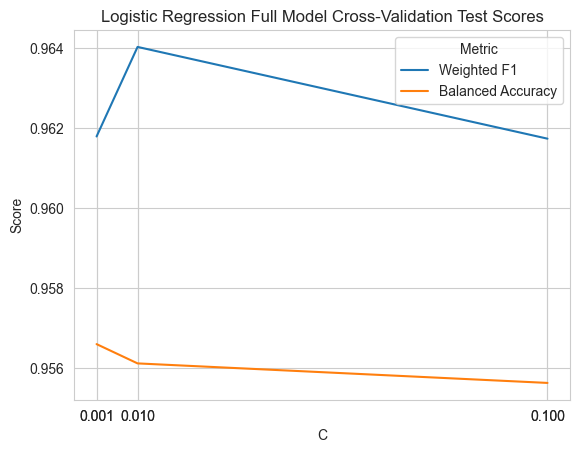

In [30]:
# Plot cross-validation test metric results for logistic regression full model
CVScoresPlot(models, log_reg_key, full_feat_key);
plt.savefig('images/log_reg_full_cv.png', dpi = 300, bbox_inches = 'tight')

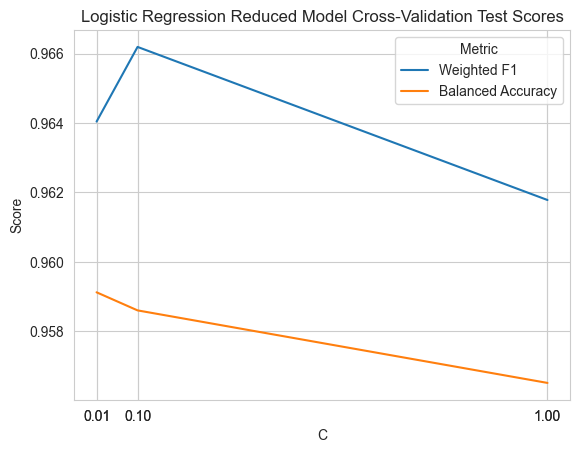

In [31]:
# Plot cross-validation test metric results for logistic regression reduced model
CVScoresPlot(models, log_reg_key, reduce_feat_key);
plt.savefig('images/log_reg_reduce_cv.png', dpi = 300, bbox_inches = 'tight')

As shown in the above plots of the mean cross-validation test scores, if balanced accuracy were used for hyperparameter tuning, a smaller L2 inverse regularization parameter (i.e., more regularization) would have been selected for both the full and reduced models.

### Random Forest Model

Of the hyperparameters tested in the grid-search cross-validation, the random forest model with 100 trees of maximum depth 20 performs best when trained on all the features, whereas 600 trees are required for the reduced feature model.

In [32]:
# Random forest full model training and hyperparameter tuning
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [10, 20, 30]}
rf = RandomForestClassifier(random_state = 31, class_weight = 'balanced')
models[rnd_fst_key] = {full_feat_key: GridSearchCrossValidation(X_train, y_train, rf, param_grid)}

Best parameters: {'max_depth': 20, 'n_estimators': 100}
Best mean CV weighted F1 score: 0.939


In [33]:
# Random forest reduced model training and hyperparameter tuning
param_grid = {'n_estimators': [500, 600, 700],
              'max_depth': [10, 20, 30]}
models[rnd_fst_key][reduce_feat_key] = GridSearchCrossValidation(X_train_reduced, y_train, rf, param_grid)

Best parameters: {'max_depth': 20, 'n_estimators': 600}
Best mean CV weighted F1 score: 0.941


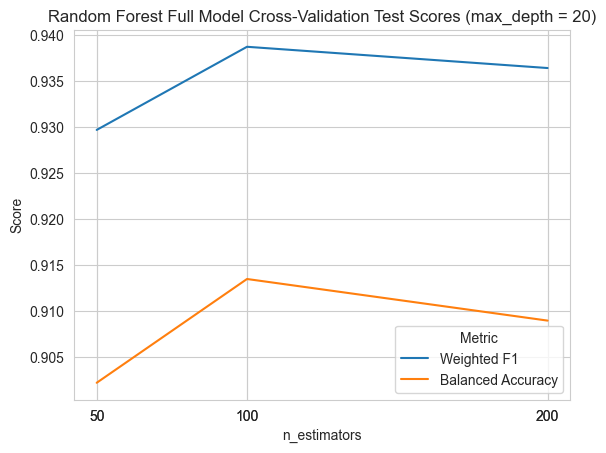

In [34]:
# Plot cross-validation test metric results for random forest full model
CVScoresPlot(models, rnd_fst_key, full_feat_key, 'max_depth', 20);
plt.savefig('images/rnd_fst_full_cv.png', dpi = 300, bbox_inches = 'tight')

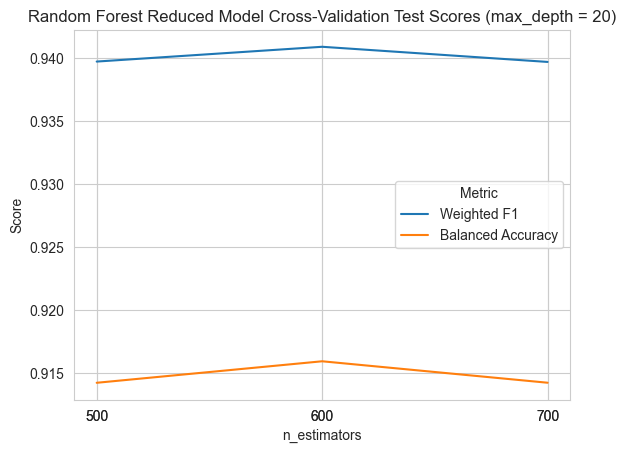

In [35]:
# Plot cross-validation test metric results for random forest reduced model
CVScoresPlot(models, rnd_fst_key, reduce_feat_key, 'max_depth', 20);
plt.savefig('images/rnd_fst_reduce_cv.png', dpi = 300, bbox_inches = 'tight')

In the above plots of random forest cross-validation scores for models with trees of maximum depth of 20, the full model with 100 trees and the reduced model with 600 trees perform best on both the balanced accuracy and weighted F1 metrics.

### Adaptive Boosting Model

To attain reasonable training times and avoid overfitting, the maximum number of features considered for each base estimator is limited to the square root of the total number of features. The adaptive boosting model with 500 estimators trained on all the features performs best, whereas only 100 estimators are needed for the model trained on the reduced features set.

In [36]:
# Adaptive boosting full model training and hyperparameter tuning
param_grid = {'n_estimators': [400, 500, 600]}
base_estimator = DecisionTreeClassifier(max_depth = 1, max_features = 'sqrt', class_weight = 'balanced')
ab = AdaBoostClassifier(base_estimator, random_state = 31)
models[ada_bst_key] = {full_feat_key: GridSearchCrossValidation(X_train, y_train, ab, param_grid)}

Best parameters: {'n_estimators': 500}
Best mean CV weighted F1 score: 0.912


In [37]:
# Adaptive boosting reduced model training and hyperparameter tuning
param_grid = {'n_estimators': [50, 100, 200]}
models[ada_bst_key][reduce_feat_key] = GridSearchCrossValidation(X_train_reduced, y_train, ab, param_grid)

Best parameters: {'n_estimators': 100}
Best mean CV weighted F1 score: 0.816


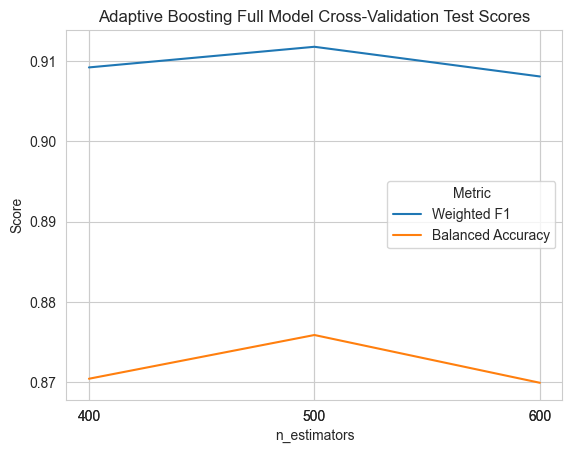

In [38]:
# Plot cross-validation test metric results for adaptive boosting full model
CVScoresPlot(models, ada_bst_key, full_feat_key);
plt.savefig('images/ada_bst_full_cv.png', dpi = 300, bbox_inches = 'tight')

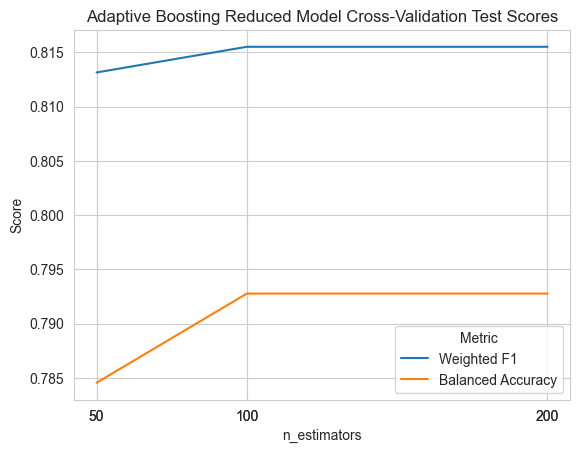

In [39]:
# Plot cross-validation test metric results for adaptive boosting reduced model
CVScoresPlot(models, ada_bst_key, reduce_feat_key);
plt.savefig('images/ada_bst_reduce_cv.png', dpi = 300, bbox_inches = 'tight')

In the above plots of the adaptive boosting cross-validation scores, the full model with 500 estimators performs best on both metrics, and the reduced model has no improvement beyond 100 estimators on both metrics.

### Support Vector Machine Model

The linear kernel performs best for the support vector machine models trained on both the full and reduced set of features. In addition, for the linear kernel, the L2 inverse regularization strength hyperparameter C setting has no impact on the cross-validation test scores for the full and reduced models.

In [40]:
# Support vector machine classifier full model training and hyperparameter tuning
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0.1, 1, 10]}
svm = SVC(class_weight = 'balanced', random_state = 31, max_iter = 5000)
models[svm_key] = {full_feat_key: GridSearchCrossValidation(X_train, y_train, svm, param_grid)}

Best parameters: {'C': 0.1, 'kernel': 'linear'}
Best mean CV weighted F1 score: 0.963


In [41]:
# Support vector machine classifier reduced model training and hyperparameter tuning
models[svm_key][reduce_feat_key] = GridSearchCrossValidation(X_train_reduced, y_train, svm, param_grid)

Best parameters: {'C': 0.1, 'kernel': 'linear'}
Best mean CV weighted F1 score: 0.966


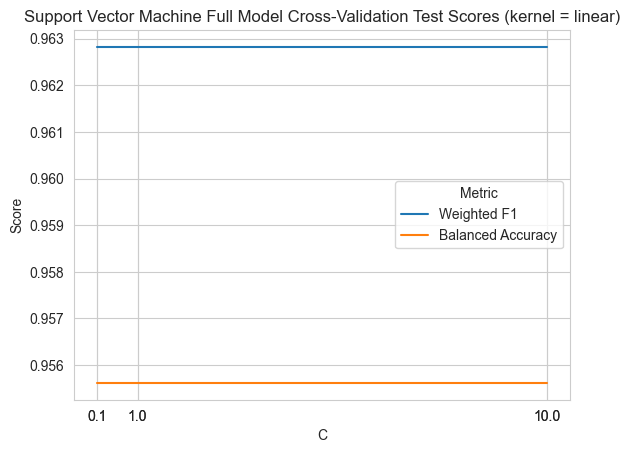

In [42]:
# Plot cross-validation test metric results for SVM full model
CVScoresPlot(models, svm_key, full_feat_key, 'kernel', 'linear');
plt.savefig('images/svm_full_cv.png', dpi = 300, bbox_inches = 'tight')

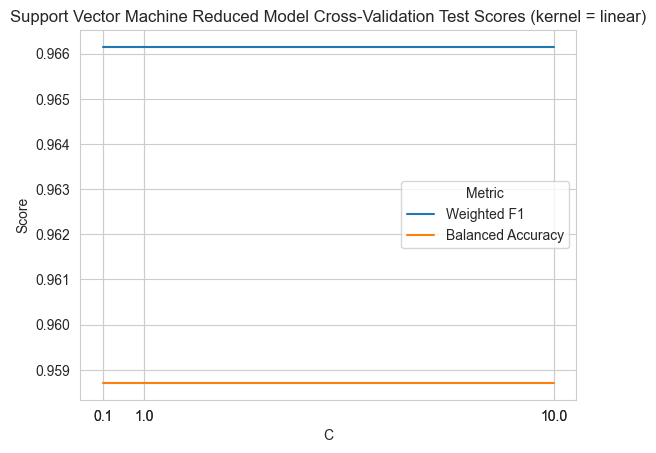

In [43]:
# Plot cross-validation test metric results for SVM reduced model
CVScoresPlot(models, svm_key, reduce_feat_key, 'kernel', 'linear');
plt.savefig('images/svm_reduce_cv.png', dpi = 300, bbox_inches = 'tight')

In the above plots of SVM cross-validation scores for the linear models, the choice of L2 inverse regularization parameter C makes no difference in the models' performance.

## Feature Importance

For further insight into the models and features, the ten most important features for each model are shown below.

Common important features:
   Logistic Regression & Support Vector Machine: {'PKP2', 'IL4', 'NAV2', 'IL1RL1', 'PLCL1', 'HDC', 'ABL1', 'FGF13', 'NMU'}
   Random Forest & Adaptive Boosting: {'SYNGR3', 'CHMP7'}


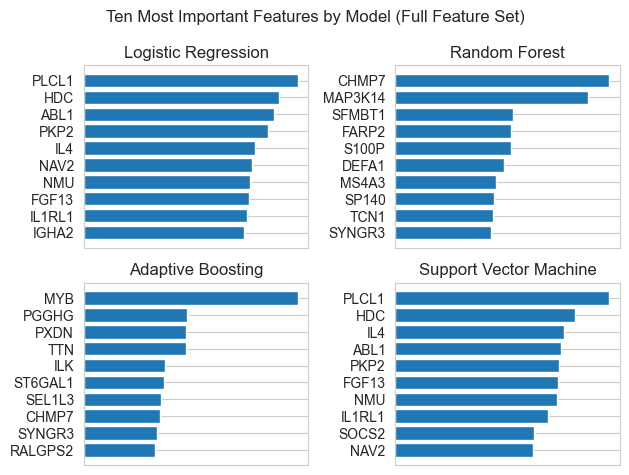

In [44]:
# Visualize ten most important features for each model

def TenImportantFeaturesPlot(models: dict, feature_set: str, verbose = True) -> plt.Figure:
    '''
    Returns MatPlotLib multi-plot of ten most important features for each model
    Optionally prints intersection of each set
    '''
    feat_imp_coef = {}
    top_ten_feat = {}

    # Get feature importances for each model
    feat_imp_coef[log_reg_key] = np.mean(np.abs(models[log_reg_key][feature_set].best_estimator_.coef_), axis = 0)
    feat_imp_coef[rnd_fst_key] = models[rnd_fst_key][feature_set].best_estimator_.feature_importances_
    feat_imp_coef[ada_bst_key] = models[ada_bst_key][feature_set].best_estimator_.feature_importances_
    feat_imp_coef[svm_key] = np.linalg.norm(models[svm_key][feature_set].best_estimator_.coef_, axis = 0)
    
    # Create dataframe
    feat_imp = pd.DataFrame(feat_imp_coef)
    feat_imp['Feature'] = models[log_reg_key][feature_set].feature_names_in_
    
    # Plot in facet grid
    fig, axs = plt.subplots(nrows = 2, ncols = 2)
    title = f'Ten Most Important Features by Model ({feature_set} Feature Set)'
    fig.suptitle(title)
    for model, ax in zip(models.keys(), axs.ravel()):
        top_ten_df = feat_imp.sort_values(model).tail(10)
        top_ten_feat[model] = set(top_ten_df.Feature.to_list())
        ax.barh(data = top_ten_df, y = 'Feature', width = model)
        ax.set_title(model)
        ax.set_xticks([])
    fig.tight_layout()

    if verbose:
        # Print common features for each possible combination 
        print('Common important features:')
        comparison_set = set(models.keys())
        for model in models.keys():
            comparison_set.remove(model)
            for other_model in comparison_set:
                intersection = top_ten_feat[model].intersection(top_ten_feat[other_model])
                if intersection:
                    print(f'   {model} & {other_model}: {intersection}')

    return fig

# Full feature set feature importances
fig = TenImportantFeaturesPlot(models, full_feat_key);
fig.savefig('images/imp_feat_full.png', dpi = 300, bbox_inches = 'tight')

The bar charts above show the ten most important features for each model trained on the full feature set. Notably, the logistic regression and the support vector machine models have nine top features in common (with some differences in rank order), and both share the same first and second most important features (`PLCL1` and `HDC`). Interestingly, none of the logistic regression and support vector machine models' most important ten features appear in the top ten of the random forest and adaptive boosting, and the two ensemble models only have two features in common (`CHMP7` and `SYNGR3`). In addition, two features (`CHMP7` and `MAP3K14`) have a much higher importance compared to the others in the random forest model, and one feature (`MYB`) is more than twice as important as the other features in the adaptive boosting model. In contrast, there is less difference in the importance of the top features for the logistic regression and support vector machines.

Common important features:
   Logistic Regression & Support Vector Machine: {'IL4', 'NAV2', 'IL1RL1', 'PLCL1', 'HDC', 'ABL1', 'FGF13', 'IFI27', 'NMU'}
   Logistic Regression & Adaptive Boosting: {'ABL1'}
   Logistic Regression & Random Forest: {'HDC'}
   Random Forest & Support Vector Machine: {'HDC'}
   Adaptive Boosting & Support Vector Machine: {'ABL1'}


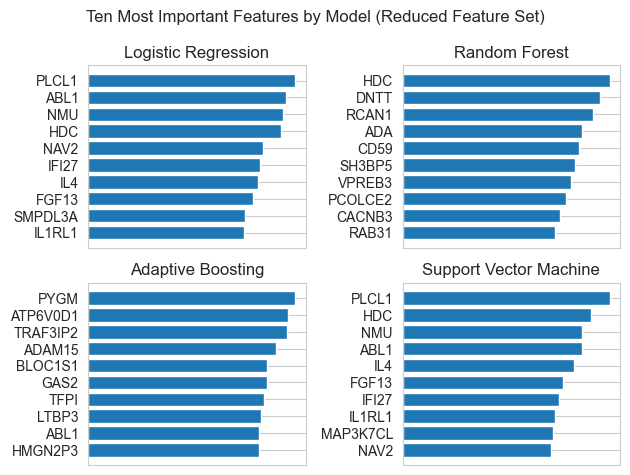

In [45]:
# Reduced feature set feature importances
fig = TenImportantFeaturesPlot(models, reduce_feat_key);
fig.savefig('images/imp_feat_reduced.png', dpi = 300, bbox_inches = 'tight')

The bar charts above display the ten most important features from the reduced feature set for each model. Again, the logistic regression and support vector machine models have nine top features in common (with differences in rank order), and the `PLCL1` feature is again the most important for both. Unlike the full models, the random forest and adaptive boosting reduced models do not have any top features in common. Another difference from the full models is that the logistic regression and support vector machine reduced models have one top feature in common with the random forest model (`HDC`), and they also have one feature in common with the adaptive boosting model (`ABL1`). Also, in contrast with the feature importances of the full random forest and adaptive boosting models, there is less of a difference in importance between the features.

## Models Summary

 **Grid-search cross-validation hyperparameter tuning** was used to fit **multiple** full and reduced feature **machine learning models** on a training data subset with weighted scoring to manage **imbalance**. For all but the logistic regression model, the F1 weighted score and balanced accuracy were maximized for the same hyperparameter settings. The logistic regression and support vector models shared nine out of the ten most important features, but there were few to no similarities in the top **feature importances** for the other models. The models' performance on test data is evaluated in the following section.

# Results and Analysis

In this section, several **visualizations** are used to compare the **models' performance** with **different evaluation metrics** for both the full and reduced models. Specifically, the optimized models' performance in classifying the test data is compared with weighted F1 and balanced accuracy prediction scores, confusion matrices, and fit and prediction times. To make more informed comparisons, 200 bootstrap samples are taken from the test set for the F1, accuracy, and prediction time measurements. Fit time estimates are obtained by fitting the model to the train data 10 times (due to runtime constraints).

In [46]:
# Get bootstrapped performance measurements for each model

def BootstrapModelMetrics(models: dict, X_train: pd.DataFrame, y_train: pd.Series,
                          X_test: pd.DataFrame, y_test: pd.Series, drop_features: pd.Index,
                          wtd_f1_key: str, bal_acc_key: str, fit_time_key: str, predict_time_key: str,
                          full_feat_key: str, reduce_feat_key: str, repetitions: int, verbose = False) -> dict:
    '''
    Return bootstrapped performance metrics for each model as nested dict
    '''
    # Initialize dict to record measurements
    measurements = {wtd_f1_key: {}, 
                    bal_acc_key: {}, 
                    fit_time_key: {}, 
                    predict_time_key: {}}
    for model_name, feat_sets in models.items():
        for metric in measurements.values():
            metric[model_name] = {full_feat_key: [], reduce_feat_key: []}

    test_df = pd.concat([X_test, y_test], axis = 1)

    for i in range(repetitions):
        if verbose:
            print('Prediction iteration:', i + 1)
        
        # Get bootstrap sample
        test_sample = test_df.sample(frac = 1, replace = True, axis = 0, 
                                     random_state = i, ignore_index = True)
        X_test_sample_full = test_sample.iloc[:,:-1]
        X_test_sample_reduced = X_test_sample_full.drop(drop_features, axis = 1)
        y_test_sample = test_sample.Disease

        for name, feat_sets in models.items():
            if verbose:
                print('  Evaluating', name)

            for feat_set, model in feat_sets.items():
                if verbose:
                    print(f'    {feat_set} Model')

                # Select appropriate feature set sample
                X_test_sample = X_test_sample_full if feat_set == full_feat_key else X_test_sample_reduced

                # Get predictions for test sample and record time
                start_time = time.perf_counter()
                y_pred_sample = model.predict(X_test_sample)
                stop_time = time.perf_counter()
                measurements[predict_time_key][name][feat_set].append(stop_time - start_time)

                # Calculate and record scores on test sample
                measurements[wtd_f1_key][name][feat_set].append(f1_score(y_test_sample, 
                                                                         y_pred_sample, 
                                                                         average = 'weighted'))
                measurements[bal_acc_key][name][feat_set].append(balanced_accuracy_score(y_test_sample, 
                                                                                         y_pred_sample))

    # Get 10 fit times for each model (due to runtime constraints)
    X_train_reduced = X_train.drop(drop_features, axis = 1)
    for name, feat_sets in models.items():
        if verbose:
            print('Measuring fit times for', name)

        for feat_set, gscv_obj in feat_sets.items():
            if verbose:
                print(f'  {feat_set} Model')

            # Get best model from GridSearchCV object
            model = gscv_obj.best_estimator_

            for _ in range(10):
                X = X_train if feat_set == full_feat_key else X_train_reduced
                start_time = time.perf_counter()
                model.fit(X, y_train)
                stop_time = time.perf_counter()
                measurements[fit_time_key][name][feat_set].append(stop_time - start_time)
    
    return measurements

def MeasurementsLongForm(measurements: dict, model_key: str, metric_key: str, 
                         feat_set_key: str, measurement_key: str) -> pd.DataFrame:
    '''
    Returns measurements as long-form dataframe
    '''
    metric_df_dict = {}
    for metric, models in measurements.items():
        model_df_dict = {}
        for model, results in models.items():
            model_df_dict[model] = pd.DataFrame(results)
        metric_df_dict[metric] = pd.concat(model_df_dict, axis = 0)
    
    long_form_df = pd.concat(metric_df_dict, axis = 0).stack().to_frame(measurement_key)
    long_form_df.index.set_names([metric_key, model_key, 'Iteration', feat_set_key], inplace = True)
    long_form_df.reset_index(inplace = True)
    
    return long_form_df

# Metric keys
wtd_f1_key = 'Weighted F1 Score'
bal_acc_key = 'Balanced Accuracy Score'
fit_time_key = 'Fit Time'
predict_time_key = 'Predict Time'
model_key = 'Model'
metric_key = 'Metric'
feat_set_key = 'Feature Set'
measurement_key = 'Measurement'

measurements = BootstrapModelMetrics(models, X_train, y_train, X_test, y_test, drop_features, 
                                     wtd_f1_key, bal_acc_key, fit_time_key, predict_time_key, 
                                     full_feat_key, reduce_feat_key, repetitions = 200)

measurements_df = MeasurementsLongForm(measurements, model_key, metric_key, feat_set_key, measurement_key)

## Prediction Scores

As explained in the Models Section above, F1 scores are the harmonic mean of recall and precision, and weighted F1 scores are the weighted average of each class' F1 score. Balanced accuracy is a weighted average of each class' accuracy scores in which majority class' scores are reduced and minority class' scores are increased, effectively balancing the scores. In a balanced dataset, it would be equivalent to the overall mean of the class accuracy scores. The models' performance on these metrics is explored in the following subsections.

### Weighted F1 Score

First, a chart of grouped box plots for each model's bootstrapped weighted F1 scores is examined below.

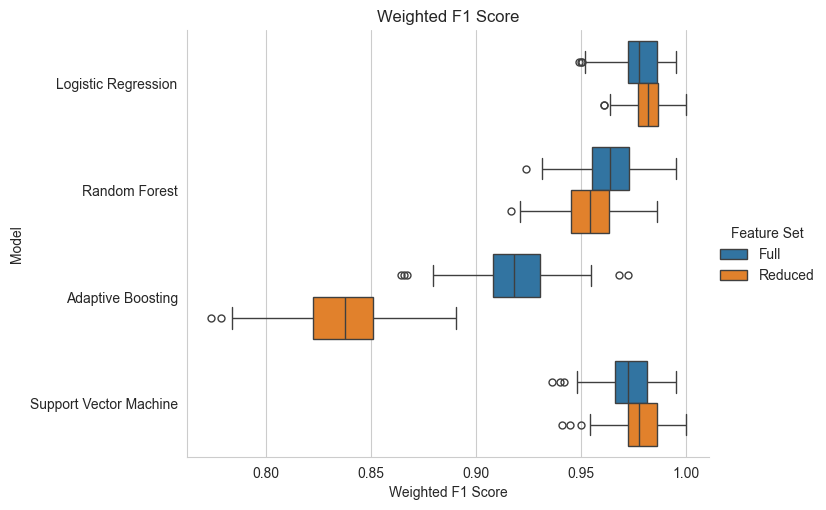

In [47]:
# Compare models
def ModelBoxPlots(long_df: pd.DataFrame, metrics: list, model_key: str, 
                  metric_key: str, feat_set_key: str, measurement_key: str, 
                  metric_type: str = None, feat_set: str = None) -> sns.FacetGrid:
    '''
    Returns Seaborn box plots of models on one or two metrics
    '''
    sub_df = None
    title = f'{metrics[0]}'
    xlabel = f'{metrics[0]}'
    hue = feat_set_key
    if feat_set:
        if len(metrics) == 2:
            sub_df = long_df[((long_df[metric_key] == metrics[0]) | (long_df[metric_key] == metrics[1])) & (long_df[feat_set_key] == feat_set)]
            hue = metric_key
            title = f'{metric_type} Metric Comparison on {feat_set} Feature Set'
            xlabel = f'{metric_type}'
        else:
            sub_df = long_df[(long_df[metric_key] == metrics[0]) & (long_df[feat_set_key] == feat_set)]
            hue = None
            title += f' on {feat_set} Feature Set'
    else: 
        sub_df = long_df[(long_df[metric_key] == metrics[0])]

    sns.set_style('whitegrid')
    ax = sns.catplot(data = sub_df, x = measurement_key, y = model_key, hue = hue, kind = 'box', aspect = 1.5)
    ax.set(title = title, xlabel = xlabel)
    
    return ax

# F1 score box plots
ModelBoxPlots(measurements_df, [wtd_f1_key], model_key, metric_key, feat_set_key, measurement_key);
plt.savefig('images/wtd_f1.png', dpi = 300, bbox_inches = 'tight')

The box plots above compare the distribution of the weighted F1 scores for each model on both the full and reduced feature sets. There is considerable overlap of the relatively narrow interquartile ranges (IQR) of the logistic regression (LR) and support vector machine (SVM) models for both the full and reduced sets, which indicates that these models might perform equally or almost equally well on this metric. In addition, the IQR of the random forest (RF) full model overlaps with the IQR of the LR and SVM full models, but not for the reduced models. The IQRs of each of the adaptive boosting (AB) models are much lower for both the full and reduced sets, and the wider IQRs and whiskers indicate much greater variability. In addition, with the exception of the RF reduced model, each of the distributions appear to be skewed to varying degrees.

To determine whether the mean weighted F1 score for each of these models is the same or different, ANOVA and (if the F-statistic is significant) pairwise tests are required. Because the variance for each of these distributions does not appear to be the same, Welch's ANOVA is recommended (Field et al., 2012). The following code performs Welch's test on the bootstrapped weighted F1 scores for all the models under the null hypothesis that there is no difference between the models in their mean weighted F1 score and a chosen significance threshold of $\alpha = 0.05$.

In [48]:
# Welch's ANOVA on weighted F1 scores of all models
filtered_df = measurements_df[(measurements_df[metric_key] == wtd_f1_key)]
pd.options.mode.chained_assignment = None
filtered_df[model_key] = filtered_df[model_key] + ' ' + filtered_df[feat_set_key]
pd.options.mode.chained_assignment = 'warn'
pg.welch_anova(data = filtered_df, dv = measurement_key, between = model_key)

,Source,ddof1,ddof2,F,p-unc,np2
0,Model,7,678.737237,1381.133749,0.0,0.916066


The Welch's F-statistic for the ANOVA on the weighted F1 scores of all models is significant because the p-value is far below the threshold $\alpha=0.05$. Therefore, we should reject the null hypothesis that there is no difference in the weighted F1 score means of each of the models.

To determine which of the models differ in their mean weighted F1 scores, we can conduct posthoc pairwise comparisons controlling for familywise error. Because we cannot assume homogeneity of variance across the models, Games and Howell's (1976) test is appropriate.

In [49]:
# Games-Howell Pairwise Comparisons
pg.pairwise_gameshowell(data = filtered_df, dv = measurement_key, between = model_key).round(3)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Adaptive Boosting Full,Adaptive Boosting Reduced,0.918,0.837,0.081,0.002,39.967,387.720,0.000,3.989
1,Adaptive Boosting Full,Logistic Regression Full,0.918,0.977,-0.059,0.001,-39.605,305.360,0.000,-3.953
2,Adaptive Boosting Full,Logistic Regression Reduced,0.918,0.982,-0.064,0.001,-44.347,277.665,0.000,-4.426
3,Adaptive Boosting Full,Random Forest Full,0.918,0.964,-0.046,0.002,-28.841,350.350,0.000,-2.879
4,Adaptive Boosting Full,Random Forest Reduced,0.918,0.955,-0.037,0.002,-22.842,361.867,0.000,-2.280
5,Adaptive Boosting Full,Support Vector Machine Full,0.918,0.972,-0.054,0.002,-35.154,328.273,0.000,-3.509
6,Adaptive Boosting Full,Support Vector Machine Reduced,0.918,0.978,-0.060,0.002,-39.914,311.283,0.000,-3.984
7,Adaptive Boosting Reduced,Logistic Regression Full,0.837,0.977,-0.140,0.002,-82.393,278.539,0.000,-8.224
8,Adaptive Boosting Reduced,Logistic Regression Reduced,0.837,0.982,-0.145,0.002,-87.474,256.768,0.000,-8.731
9,Adaptive Boosting Reduced,Random Forest Full,0.837,0.964,-0.127,0.002,-71.046,318.016,0.000,-7.091


The Games-Howell test results above indicate that the difference in weighted F1 score means for every pairwise combination of models is statistically significant except for the LR full model compared to the SVM reduced model. Thus, the weighted mean F1 score can be used to differentiate all but these two models. 

The models are ranked by weighted F1 score below along with 95% confidence intervals for the mean. 

In [52]:
# 95% confidence intervals

def EstimateConfidenceIntervals(measurements: dict, model_key: str, feat_set_key: str, 
                                lower_ci_key: str, upper_ci_key: str, alpha = 0.05) -> pd.DataFrame:
    '''
    Returns dataframe of (1 - alpha)% confidence intervals for mean of each metric for each model
    '''
    conf_ints = {}
    
    # Compute confidence intervals
    for metric, models in measurements.items():
        conf_ints[metric] = {}
        for model, feat_sets in models.items():
            conf_ints[metric][model] = {}
            for feat_set, values in feat_sets.items():
                conf_ints[metric][model][feat_set] = {}
                lower, upper = sms.DescrStatsW(values).tconfint_mean(alpha = alpha)
                conf_ints[metric][model][feat_set][lower_ci_key] = lower
                conf_ints[metric][model][feat_set][upper_ci_key] = upper        

    # Make dataframe
    metric_df_dict = {}
    for metric, models in conf_ints.items():
        model_df_dict = {}
        for model, results in models.items():
            model_df_dict[model] = pd.DataFrame(results).T
        metric_df_dict[metric] = pd.concat(model_df_dict, axis = 0)
    conf_int_df = pd.concat(metric_df_dict, axis = 1)
    conf_int_df.index.set_names([model_key, feat_set_key], inplace = True)
    
    return conf_int_df

lower_ci_key = 'Lower'
upper_ci_key = 'Upper'

conf_ints = EstimateConfidenceIntervals(measurements, model_key, feat_set_key, lower_ci_key, upper_ci_key)


# Display 95% confidence intervals for weighted F1 score means
f1_ci_sort = conf_ints.iloc[:,0:2].sort_values([(wtd_f1_key, lower_ci_key)], ascending = False).round(4)
f1_ci_sort

Weighted F1 Score        
                                               Lower   Upper
Model                  Feature Set                          
Logistic Regression    Reduced                0.9809  0.9833
Support Vector Machine Reduced                0.9767  0.9795
Logistic Regression    Full                   0.9758  0.9786
Support Vector Machine Full                   0.9706  0.9737
Random Forest          Full                   0.9622  0.9657
                       Reduced                0.9532  0.9570
Adaptive Boosting      Full                   0.9156  0.9207
                       Reduced                0.8340  0.8401

The table above and plot below display the 95% confidence intervals for the weighted F1 score means in descending order. Note that none of the confidence intervals overlap except for the full LR and reduced SVM models. Confidence intervals which do not overlap correspond to p-values of $0.006$ or less (Cumming & Finch, 2005), although this value should be adjusted for family-wise error depending on the number of comparisons.

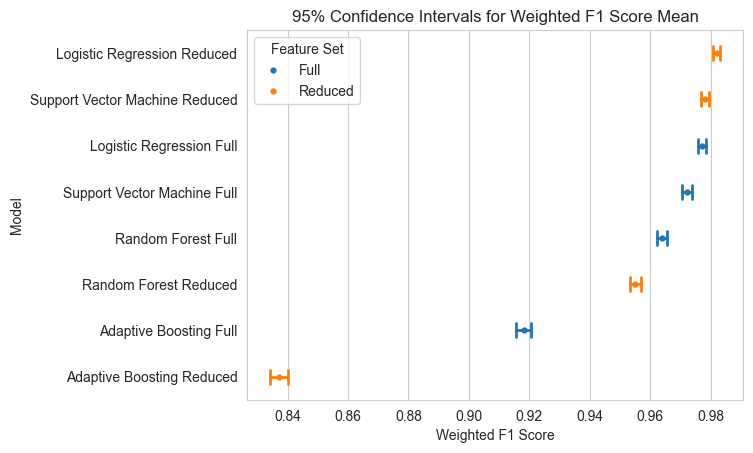

In [54]:
def ModelsConfidenceIntervalsPlot(long_df: pd.DataFrame, conf_ints: pd.DataFrame, metric: str, 
                                  model_key: str, metric_key: str, feat_set_key: str, 
                                  measurement_key: str, lower_ci_key: str, ascending = False) -> plt.Axes:
    '''
    Returns MatPlotLib plot of models' 95% confidence intervals for means of metric
    '''
    # Filter long format dataframe
    filtered_df = long_df[(long_df[metric_key] == metric)]
    pd.options.mode.chained_assignment = None
    filtered_df[model_key] = filtered_df[model_key] + ' ' + filtered_df[feat_set_key]
    pd.options.mode.chained_assignment = 'warn'

    # Order models by lower CI bound
    metric_ci_sorted_df = conf_ints.loc[:, metric].sort_values(lower_ci_key, ascending = ascending)
    idx = metric_ci_sorted_df.index
    order = (idx.get_level_values(0) + ' ' + idx.get_level_values(1)).to_list()

    # Plot
    sns.set_style('whitegrid')
    ax = sns.pointplot(data = filtered_df, x = measurement_key, y = model_key, hue = feat_set_key, 
                       order = order, errorbar = ('ci', 95), capsize = 0.3, linestyle = 'none', 
                       markersize = 3, linewidth = 2)
    ax.set(title = f'95% Confidence Intervals for {metric} Mean', xlabel = metric)

    return ax

ModelsConfidenceIntervalsPlot(measurements_df, conf_ints, wtd_f1_key, model_key, metric_key, feat_set_key, measurement_key, lower_ci_key);
plt.savefig('images/f1_ci.png', dpi = 300, bbox_inches = 'tight')

As shown above, the LR reduced model performs best on the weighted F1 score, followed by the SVM reduced model, although the latter model's performance is indistinguisable from the LR full model. Both the full and reduced AB models perform the worst. Contrasting performance on full versus feature sets, both the LR and SVM reduced models perform better than their respective full models. In contrast, the RF and AB full models perform better than their corresponding reduced models. However, the full ensemble models' performance is still worse than the LR and SVM full models. 

### Balanced Accuracy Score

The grouped box plots below compare the distribution of the bootstrapped balanced accuracy scores for each model. The models' relative performance on this metric follow similar patterns as the weighted F1 scores above: The median scores of the LR and SVM models are relatively close to one another and higher than the ensemble (RF and AB) models; the IQRs of the full and reduced LR and SVM models overlap; the IQR of the RF full model overlaps with the full and reduced SVM models; and there is a wider spread in all the ensemble models.

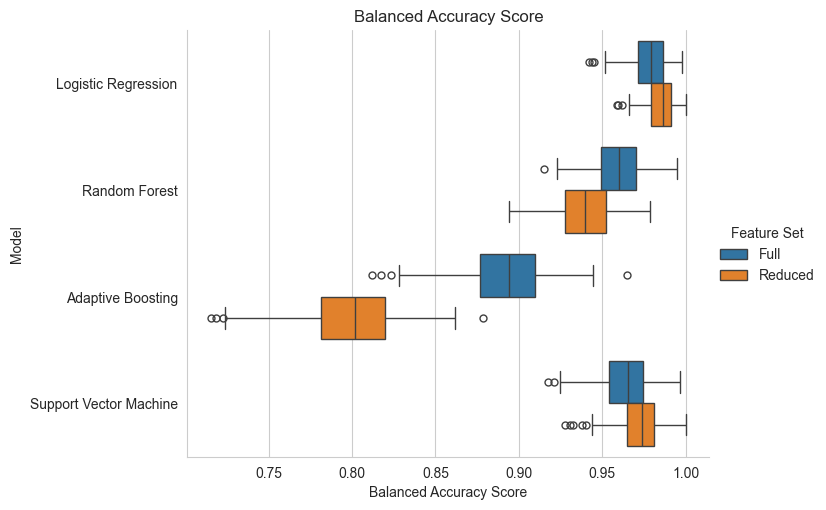

In [55]:
# Balanced accuracy box plots
ModelBoxPlots(measurements_df, [bal_acc_key], model_key, metric_key, feat_set_key, measurement_key);
plt.savefig('images/bal_acc.png', dpi = 300, bbox_inches = 'tight')

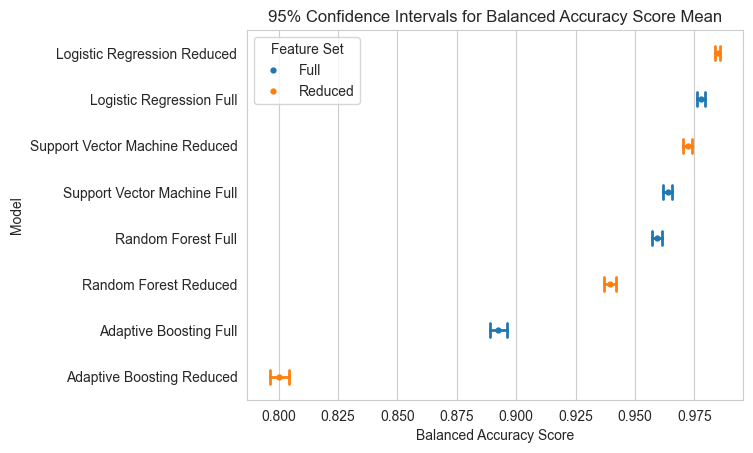

In [56]:
ModelsConfidenceIntervalsPlot(measurements_df, conf_ints, bal_acc_key, model_key, metric_key, feat_set_key, measurement_key, lower_ci_key);
plt.savefig('images/acc_ci.png', dpi = 300, bbox_inches = 'tight')

In the above plot of 95% confidence intervals for the mean of the balanced accuracy scores for each model, only the SVM and RF full models appear to overlap. Unlike the weighted F1 score results, both the full and reduced LR models appear to perform better than the SVM models on this metric. Similar to the F1 score results, the same pattern of the LR and SVM reduced models performing better than their full counterparts can be observed, and the full ensemble models perform better than their respective reduced versions.

### Score Metric Comparison

The following chart compares the box plots of the weighted F1 and balanced accuracy scores for each reduced model. With the exception of the AB model, there is considerable overlap of the IQRs of each score metric for each respective model, and the same relative performance is observed.

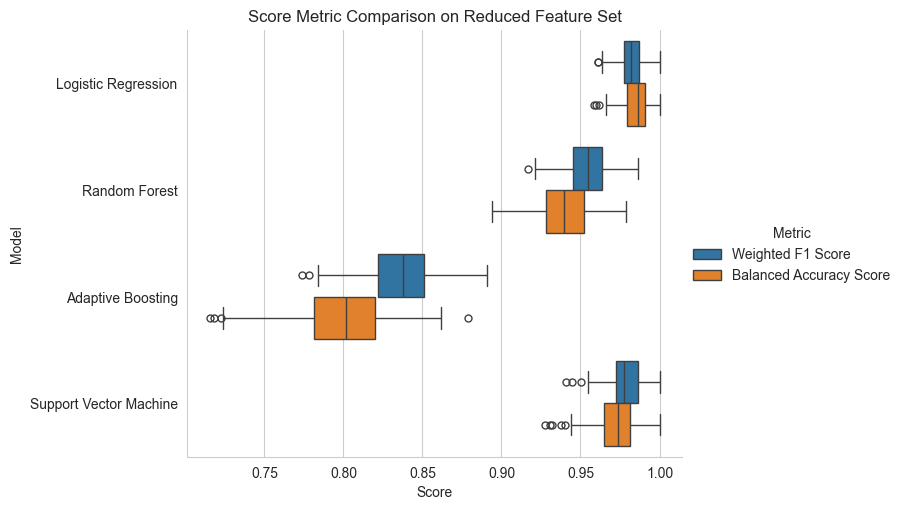

In [57]:
# Compare F1 and accuracy scores of reduced models
ModelBoxPlots(measurements_df, [wtd_f1_key, bal_acc_key], model_key, metric_key, feat_set_key, measurement_key, metric_type = 'Score', feat_set = reduce_feat_key);
plt.savefig('images/f1_acc_reduce.png', dpi = 300, bbox_inches = 'tight')

The chart below compares box plots of both score metrics on the full models. There is even greater overlap of the IQRs of both metrics for each respective model.

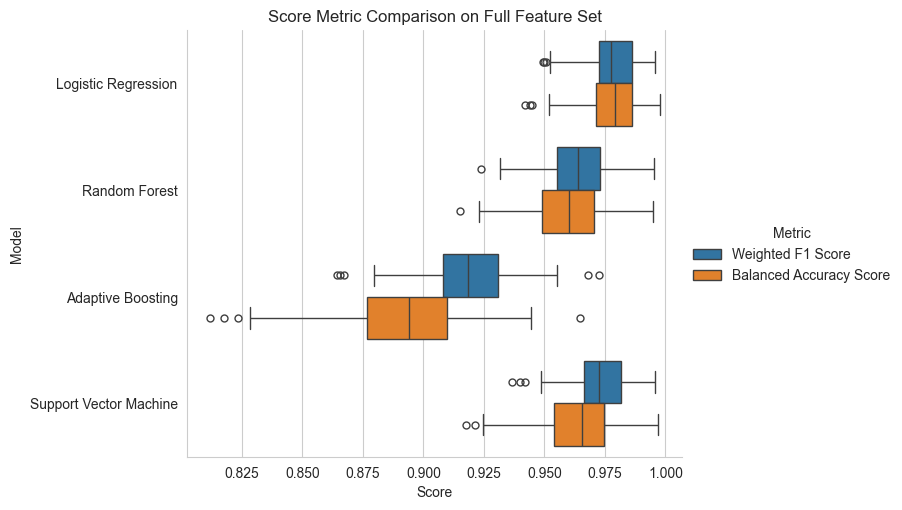

In [58]:
# Compare F1 and accuracy scores of full models
ModelBoxPlots(measurements_df, [wtd_f1_key, bal_acc_key], model_key, metric_key, feat_set_key, measurement_key, metric_type = 'Score', feat_set = full_feat_key);
plt.savefig('images/f1_acc_full.png', dpi = 300, bbox_inches = 'tight')

## Confusion Matrices

A model's performance in accurately classifying each class can be examined in detail with a confusion matrix. The confusion matrices of the two models with the highest weighted F1 scores and the model with the worst F1 score are displayed below.

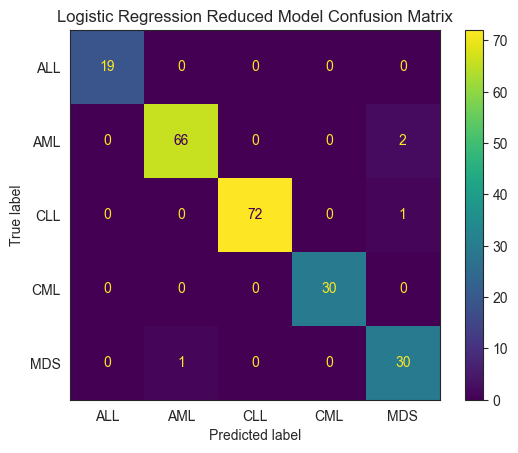

In [59]:
# Examine confusion matrices
def ConfusionMatrixPlot(X_test: pd.DataFrame, y_test: pd.Series, models: dict, 
                        model_name: str, feat_set: str) -> ConfusionMatrixDisplay:
    '''
    Return Confusion Matrix Display plot for given model
    '''
    y_predict = models[model_name][feat_set].predict(X_test)
    labels = np.sort(y_test.unique())
    sns.set_style('white')
    cm = confusion_matrix(y_test, y_predict)
    cmd = ConfusionMatrixDisplay(cm, display_labels = labels)
    cmd.plot()
    cmd.ax_.set_title(f'{model_name} {feat_set} Model Confusion Matrix')
    return cmd

# Plot logistic regression reduced model confusion matrix
ConfusionMatrixPlot(X_test_reduced, y_test, models, log_reg_key, reduce_feat_key);
plt.savefig('images/log_reg_reduce_conf_mtx.png', dpi = 300, bbox_inches = 'tight')

The confusion matrix for the model with the highest weighted F1 score (i.e., the LR reduced model) is displayed above. It only misclassified two AML samples (out of 68) as MDS, one CLL sample (out of 73) as MDS, and one MDS sample (out of 31) as AML. Thus, AML and MDS appear to be the classes most often confused for one another. Notably, it did not misclassify any of the two most underrepresented classes: CML and ALL.

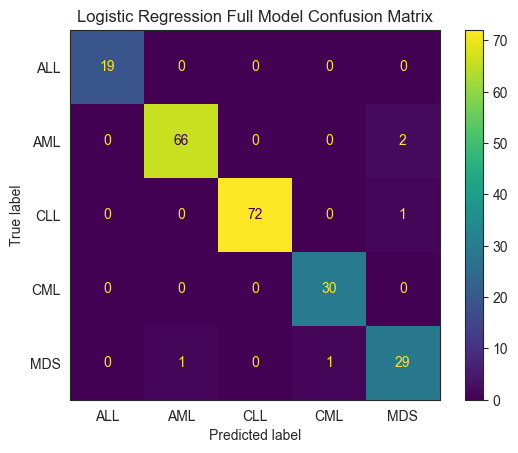

In [60]:
# Plot logistic regression full model confusion matrix
ConfusionMatrixPlot(X_test, y_test, models, log_reg_key, full_feat_key);
plt.savefig('images/log_reg_full_conf_mtx.png', dpi = 300, bbox_inches = 'tight')

The confusion matrix for the LR full model above differs from the reduced model only by one additional misclassification of MDS as CML.

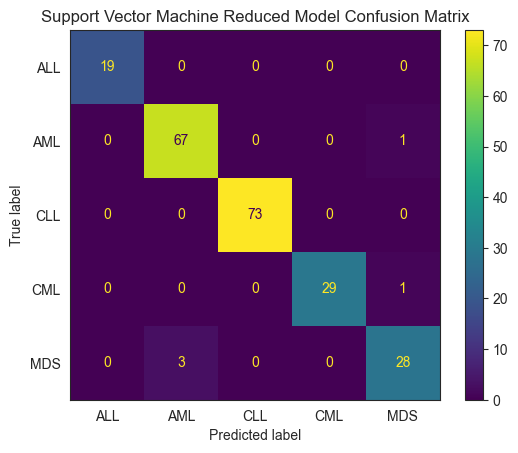

In [61]:
# Plot SVM reduced model confusion matrix
ConfusionMatrixPlot(X_test_reduced, y_test, models, svm_key, reduce_feat_key);
plt.savefig('images/svm_reduce_conf_mtx.png', dpi = 300, bbox_inches = 'tight')

The confusion matrix for the SVM reduced model above shows that three MDS samples were misclassifed as AML, one AML sample was misclassified as MDS, and one CML sample was classifed as MDS. Thus, compared to the LR models, this model does a poorer job of classifying MDS correctly, but a better job of classifying AML. It did not misclassify any of the most underrepresented class: ALL.

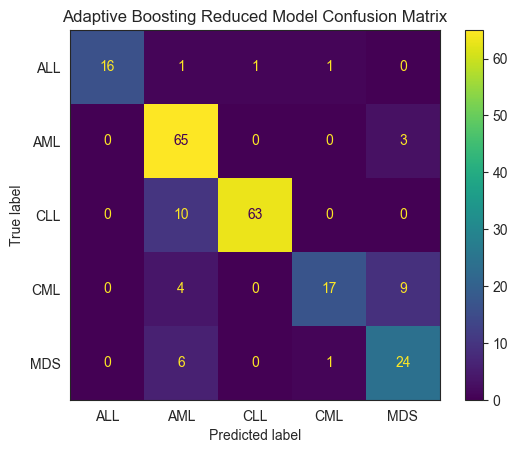

In [62]:
# Plot adaptive boosting reduced model confusion matrix
ConfusionMatrixPlot(X_test_reduced, y_test, models, ada_bst_key, reduce_feat_key);
plt.savefig('images/ada_bst_reduce_conf_mtx.png', dpi = 300, bbox_inches = 'tight')

The confusion matrix for the worst performing model (i.e., the AB reduced model) is shown above. It misclassified 13 CML samples, 10 CLL samples, 7 MDS samples, 3 AML samples, and 3 ALL samples. CLL was most often mistaken for AML, and CML was most often mistaken for MDS. It is obviously a much worse classifier than the LR and SVM models above.

## Speed

Models can also be evaluated in terms of how long they take to be trained (i.e., fit) and the time to make predictions on unseen data. The models' performance in this regard is examined in the following subsections.

### Fit Time

The chart below compares box plots for the fit (i.e., training) time for each of the models. There is more variance in the fit times for the slower models: the full and reduced LR, the reduced RF, and the full AB. In contrast, there is relatively little variance in the faster models: the full and reduced SVM, the reduced AB, and the full RF model.

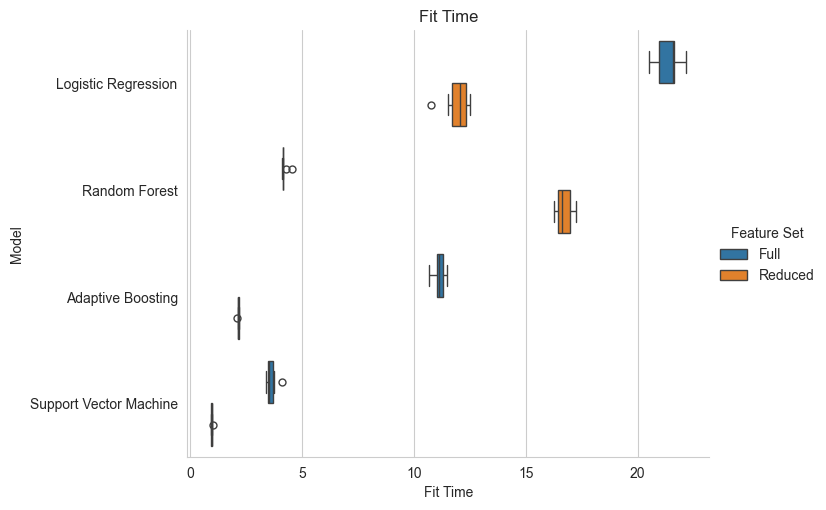

In [63]:
# Fit time box plots
ModelBoxPlots(measurements_df, [fit_time_key], model_key, metric_key, feat_set_key, measurement_key);
plt.savefig('images/fit_time.png', dpi = 300, bbox_inches = 'tight')

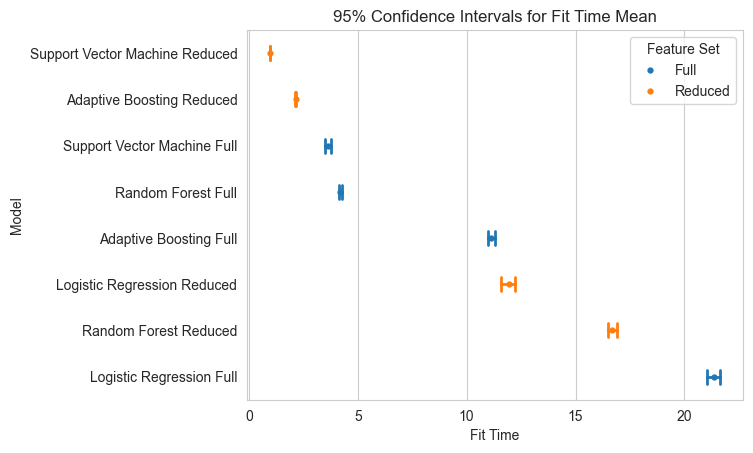

In [64]:
ModelsConfidenceIntervalsPlot(measurements_df, conf_ints, fit_time_key, model_key, metric_key, feat_set_key, measurement_key, lower_ci_key, ascending = True);
plt.savefig('images/fit_time_ci.png', dpi = 300, bbox_inches = 'tight')

In the confidence interval chart above, none of the intervals overlap. The SVM reduced model is the fastest, followed by the AB reduced model. The LR full model is the slowest.

### Prediction Time

The chart below compares box plots of the prediction time for each of the models. There is much greater variation in the times for the two slowest models: AB and SVM full models. In contrast, there is very little variation in the times for the fastest models: LR and RF.

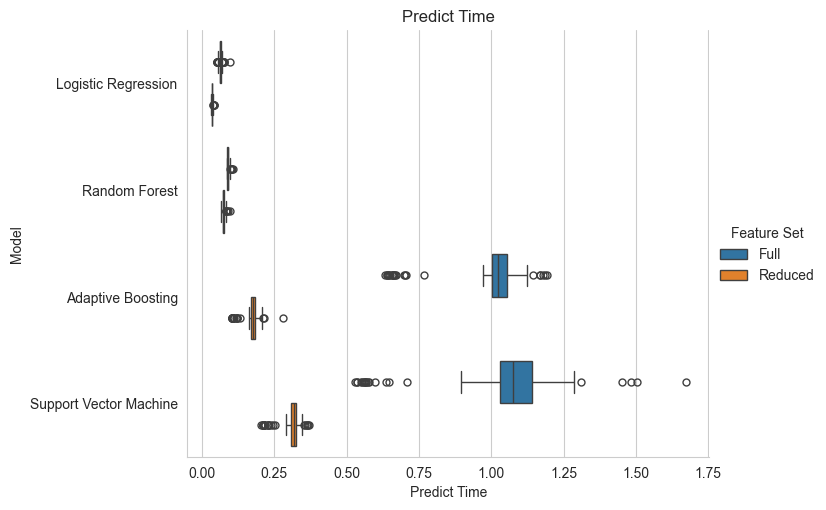

In [65]:
# Prediction time box plots
ModelBoxPlots(measurements_df, [predict_time_key], model_key, metric_key, feat_set_key, measurement_key);
plt.savefig('images/predict_time.png', dpi = 300, bbox_inches = 'tight')

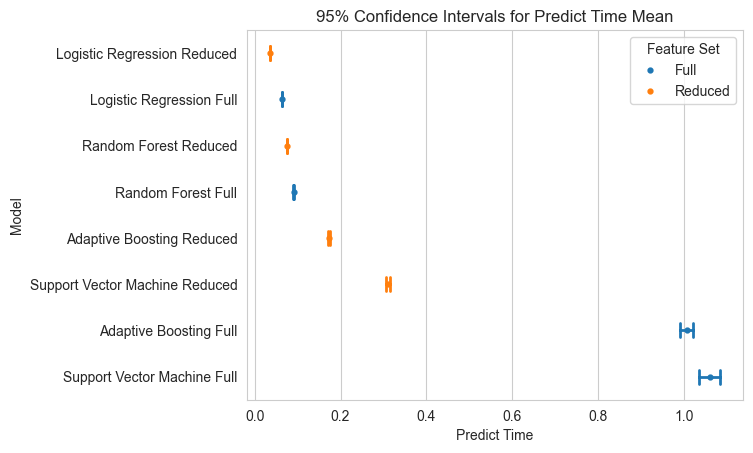

In [66]:
ModelsConfidenceIntervalsPlot(measurements_df, conf_ints, predict_time_key, model_key, metric_key, feat_set_key, measurement_key, lower_ci_key, ascending = True);
plt.savefig('images/predict_time_ci.png', dpi = 300, bbox_inches = 'tight')

In the confidence interval chart above, none of the intervals overlap. Both the full and reduced LR models are the fastest, followed by the RF models. The SVM full model is the slowest and the AB full model is next slowest.

### Time Metric Comparison

The following chart compares the box plots of the fit and predict times for each of the reduced models.

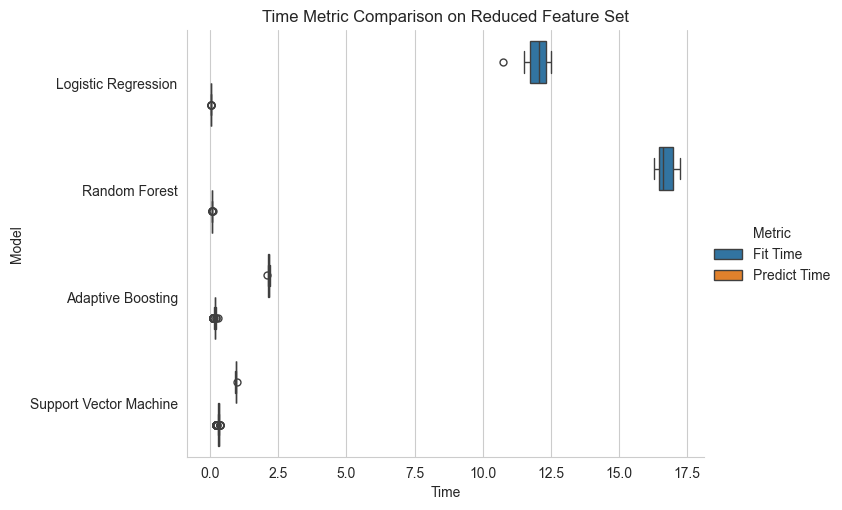

In [67]:
# Compare fit and predict times of reduced models
ModelBoxPlots(measurements_df, [fit_time_key, predict_time_key], model_key, metric_key, feat_set_key, measurement_key, metric_type = 'Time', feat_set = reduce_feat_key);
plt.savefig('images/fit_predict_time_reduce.png', dpi = 300, bbox_inches = 'tight')

The above chart compares the fit and prediction times for each model on the reduced feature set. There is a sharp difference between fit and prediction times for both the LR and RF models, while the other two (AB and SVM) have much more similar times.

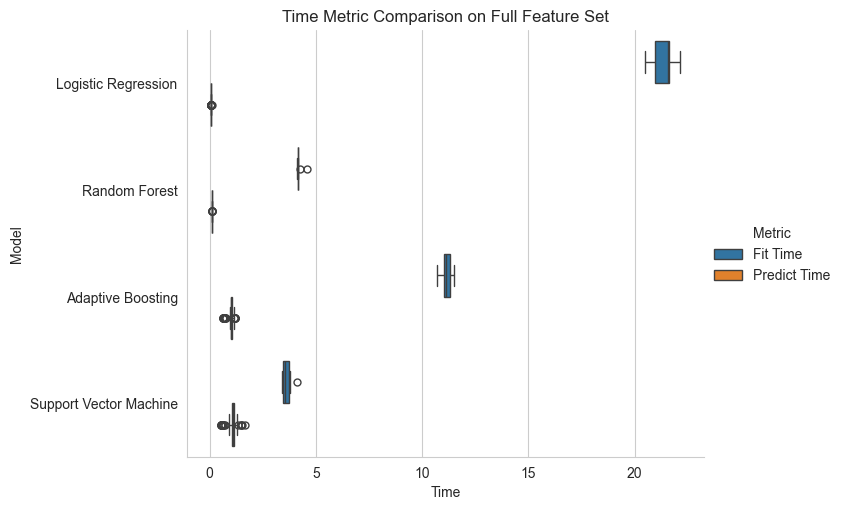

In [68]:
# Compare fit and predict times of full models
ModelBoxPlots(measurements_df, [fit_time_key, predict_time_key], model_key, metric_key, feat_set_key, measurement_key, metric_type = 'Time', feat_set = full_feat_key);
plt.savefig('images/fit_predict_time_full.png', dpi = 300, bbox_inches = 'tight')

The chart above compares the fit and predict times for the models on the full feature set. There is a sharp difference in fit and prediction time for the LR and AB models with fit time taking much longer than prediction.

## Results and Analysis Summary

This section compared the **models' performance** on **various evaluation metrics** with several **visualizations.** To summarize, the logistic regression reduced model performed best on both the weighted F1 and balanced accuracy metrics, had the fastest prediction time, and did not misclassify the two smallest minority classes; however, it had the second slowest training time of the reduced models. The support vector machine reduced model tied with the logistic regression full model for second best on the weighted F1 metric, but the support vector machine reduced model had the slowest prediction time of the reduced models. The worst performing model in terms of F1 and accuracy scores was the adaptive boosting reduced model. The support vector machine full model had the slowest prediction time, and the logistic regression full model had the slowest fit time. The implications of these results are discussed in the next section.  

# Discussion

## Learning and Takeaways

Comparing the results and analysis of the models above, there are several points that can be taken away and learned from this project.

### Class Imbalance

As discussed in the Data Cleaning Section, it is unrealistic to expect samples from the population of leukemia patients to be balanced between classes of leukemia. Thus, it is important to select machine learning models that can perform well on imbalanced data for the diagnostic differentiation of leukemia. For this reason, the class frequencies in this dataset were intentionally adjusted through undersampling to match the imbalanced general population class frequencies.

Generalized linear models, such as logistic regression, are often said to be sensitive to data imbalance; however, this project has shown that, for this dataset at least, such weaknesses can be managed through careful choices in training, such as stratification in both cross-validation and train-test splits, the use of inverse population weights in models, regularization, and weighted performance metrics. These strategies proved to be effective as the logistic regression model outperformed even the ostensibly robust ensemble models.

### Dimension Reduction

The comparison of models trained on full-feature versus reduced-feature sets in this project provides insight into two important considerations in machine learning: (multi)collinearity and dimensionality.

(Multi)collinearity is another potential detriment to generalized linear models, such as logistic regression; however, contrary to the prevailing wisdom, the logistic regression model outperformed the supposedly robust ensemble models even on the highly multicollinear full feature set. Again, this points to the effectiveness of L2 regularization, which presumably mitigated the multicollinearity of the full-feature training data.

Random forest and support vector machine models are said to be robust to high-dimensionality. Indeed, the random forest model performed better in terms of accuracy, F1 score, and fit time on the full feature set compared to the reduced feature set, but it was still outperformed in terms of accuracy, F1 score, and prediction speed by the logistic regression model on the full set. The support vector machine model performed well in terms of accuracy and F1 score on the full feature set compared to the ensemble models, but had slower prediction times. Furthermore, it was more accurate on the reduced feature set, contradicting claims of high-dimension robustness. The logistic regression model did perform better on the reduced feature set than on the full set, so in that regard at least, the advice to reduce dimensions for logistic regression models appears to be appropriate.

### Score Metrics 

Two score metrics were compared in this project: weighted F1 and balanced accuracy. Both metrics account for class imbalance but in different ways. The weighted F1 score places more weight on the F1 scores of the larger classes, while balanced accuracy attempts to even out the imbalance by increasing the scores of the smaller classes and reducing the scores of the larger classes. 

Despite these differences, the same hyperparameters would have been chosen for either metric during the training phase, except for the logistic regression model, which would have resulted in more L2 regularization according to the balanced accuracy scores. Furthermore, similar relative differences in performance were observed on the test data for both metrics.

With the exception of the logistic regression model, the balanced accuracy was lower, suggesting that it might be a more conservative metric than weighted F1 score for imbalanced multinomial classfication, but further investigation is necessary to support such a conjecture.

### Simplicity

Another important consideration in selecting machine learning models is simplicity in both implementation and interpretation. 

Considerations in implementation simplicity include data preparation, hyperparameter tuning, and runtime complexity. Although the logistic regression and support vector machines require scaling the data, they have fewer hyperparameters to tune. Ensemble methods do not require data scaling, but they have a large number of hyperparameters that can be tuned: the number of trees, the depth of those trees, the number of features considered, the maximum number of leaf nodes, and so on. This means that they can take even longer to tune and train. In terms of runtime complexity though, it is important not only to consider the training time, but the prediction time, as it is the latter which will ultimately be performed far more times in production, than the training step. In this regard, the logistic regression and random forest models were fastest.

Interpretation simplicity is another important consideration. In this regard, the logistic regression model is relatively straightforward. The coefficient vector for each feature represents the additive log-odds of predicting each class while holding all other predictors constant. Although, as shown in the Models Section, feature importance can be interpreted for each of the models in this project, their explanation is less straightforward. The support vector machine interpretation involves multidimensional vectors, and the ensemble model interpretations involve interpreting information gain through purity or entropy.

## Issues

Some of the issues that arose during this project include statistical power, unexpected poor ensemble model performance, and dimension reduction methods.

### Statistical Power

Although it would have been advantageous in terms of statistical power to use the large number of samples in the source dataset, it was also difficult to justify its class imbalance which was not even close to the population class frequencies. Although oversampling strategies were considered, consultation of the literature revealed that such strategies do not ultimately overcome the problem of lacking information which they purport to address, so undersampling is preferred (Verzino, 2021). As a result, the number of samples was far lower than the number of dimensions, and therefore, it is possible that this study lacked the power to detect differences such as between the reduced logistic regression and full support vector machine models.

### Ensemble Models

Despite being hailed as robust to high dimensionality and class imbalance, the ensemble models did not perform as well as the non-ensemble models. This was unexpected and might be due to inadequate tuning of their many hyperparameters in the interest of meeting project implementation time constraints.

### Dimension Reduction

As explained in the Models Section above, the time complexity of the recommended method of iteratively removing features with high variance inflation factors prohibited its implementation, so correlation was used as an approximation instead; however, this might result in dropping more features than necessary, adversely affecting performance.

## Future Improvements

To address the above issues, there are several improvements that should be explored in future research.

### Statistical Power

If possible, future research should include larger sample sizes while maintaining a similar class balance to the population. This would increase statistical power and facilitate the detection of smaller effects. Strategic selection of additional datasets from the NCBI data repository could make this possible.

### Comprehensive Hyperparameter Tuning

Due to project time constraints, grid search cross-validation hyperparameter tuning was selected; however, finer hyperparameter tuning of the models could potentially result in better performance, especially in the ensemble methods.

### Dimension Reduction Methods

The impact of the choice of dimension reduction method on model performance should be investigated by comparing different methods, such as principal components analysis and permutation feature importance. It is possible that model performance could improve depending on the choice of method.

# Conclusion

The aim of this project was to compare the effectiveness of several supervised machine learning algorithms on the multinomial classification task of the differential diagnosis of leukemia from imbalanced, high-dimensional genomic data. Undersampling was used to match population class frequencies. Logistic regression outperformed the support vector machine, random forest, and adaptive boosting models on both full and reduced feature sets. The support vector machine model came in a close second, but it had longer prediction times than the logistic regression model. Future research should address limitations in statistical power, refinement of hyperparameter tuning, and the effect of dimension reduction method.

# References

American Cancer Society. (2024, November 21). _Key statistics for myelodysplastic syndromes (MDS)._ [https://www.cancer.org/cancer/types/myelodysplastic-syndrome/about/key-statistics.html](https://www.cancer.org/cancer/types/myelodysplastic-syndrome/about/key-statistics.html)

American Cancer Society. (2025a, January 16). _Key statistics for acute lymphocytic leukemia._ [https://www.cancer.org/cancer/types/acute-lymphocytic-leukemia/about/key-statistics.html](https://www.cancer.org/cancer/types/acute-lymphocytic-leukemia/about/key-statistics.html)

American Cancer Society. (2025b, January 16). _Key statistics for acute myeloid leukemia._ [https://www.cancer.org/cancer/types/acute-myeloid-leukemia/about/key-statistics.html](https://www.cancer.org/cancer/types/acute-myeloid-leukemia/about/key-statistics.html)

American Cancer Society. (2025c, January 16). _Key statistics for chronic lymphocytic leukemia._ [https://www.cancer.org/cancer/types/chronic-lymphocytic-leukemia/about/key-statistics.html](https://www.cancer.org/cancer/types/chronic-lymphocytic-leukemia/about/key-statistics.html)

American Cancer Society. (2025d, January 16). _Key statistics for chronic myeloid leukemia._ [https://www.cancer.org/cancer/types/chronic-myeloid-leukemia/about/statistics.html](https://www.cancer.org/cancer/types/chronic-myeloid-leukemia/about/statistics.html)

Cumming, G., & Finch, S. (2005). Inference by eye: Confidence intervals and how to read pictures of data. _American Psychologist, 60_(2), 170-180. [https://psycnet.apa.org/doi/10.1037/0003-066X.60.2.170](https://psycnet.apa.org/doi/10.1037/0003-066X.60.2.170)

Dormann, C. F., Elith, J., Bacher, S., Buchmann, C., Carl, G., Carré, G., Marquéz, J. R. G., Gruber, B., Lafourcade, B., Leitão, P. J., Münkemüller, T., McClean, C., Osborne, P. E., Reineking, B., Schröder, B., Skidmore, A.K., Zurell, D., & Lautenbach, S. (2013), Collinearity: A review of methods to deal with it and a simulation study evaluating their performance. _Ecography, 36,_ 27-46. [https://doi.org/10.1111/j.1600-0587.2012.07348.x](https://doi.org/10.1111/j.1600-0587.2012.07348.x)

Fernández, A., García, S., Galar, M., Prati, R. C., Krawczyk, B., & Herrera, F. (2018). _Learning from imbalanced data sets._ Springer.

Ferré, J. (2009). Regression diagnostics. In S. D. Brown, R. Tauler, & B. Walczak (Eds.), _Comprehensive chemometrics_ (pp. 33-89). Elsevier. [https://doi.org/10.1016/B978-044452701-1.00076-4](https://doi.org/10.1016/B978-044452701-1.00076-4)

Field, A., Field, Z., & Miles, J. (2012). _Discovering statistics using R._ Sage.

Games, P. A., & Howell, J. F. (1976). Pairwise multiple comparison procedures with unequal n’s and/or variances: a Monte Carlo study. _Journal of Educational Statistics, 1_(2), 113-125. [https://doi.org/10.3102/10769986001002113](https://doi.org/10.3102/10769986001002113)

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). _An introduction to statistical learning with applications in R_ [2nd ed.]. Springer. [https://www.statlearning.com](https://www.statlearning.com) 

Kuhn, M. (2008). Building predictive models in R using the caret package. _Journal of Statistical Software, 28_(5), 1-26. [https://doi.org/10.18637/jss.v028.i05](https://doi.org/10.18637/jss.v028.i05)

Munzner, T. (2015). _Visualization analysis & design._ Taylor & Francis.

National Center for Biotechnology Information. (2024, July 16). Gene expression omnibus overview [Data repository]. _National Library of Medicine._ [https://www.ncbi.nlm.nih.gov/geo/info/overview.html](https://www.ncbi.nlm.nih.gov/geo/info/overview.html)

National Center for Biotechnology Information. (2025, January 4). Gene database. _National Library of Medicine._ [https://www.ncbi.nlm.nih.gov/gene/](https://www.ncbi.nlm.nih.gov/gene/)

Provost, F. (2000). _Machine learning from imbalanced data sets 101_ (Technical Report WS-00-05). Association for the Advancement of Artificial Intelligence.  [https://aaai.org/papers/ws00-05-001-machine-learning-from-imbalanced-data-sets-101/](https://aaai.org/papers/ws00-05-001-machine-learning-from-imbalanced-data-sets-101/)

van der Maaten, L., & Hinton, G., (2008). Visualizing data using t-SNE. _Journal of Machine Learning Research, 9_(86), 2579-2605. [https://www.jmlr.org/papers/v9/vandermaaten08a.html](https://www.jmlr.org/papers/v9/vandermaaten08a.html)

Verzino, G. (2021, June 27). Why balancing classes is over-hyped: Three reasons you may not need to balance your data set. _Towards Data Science._ [https://towardsdatascience.com/why-balancing-classes-is-over-hyped-e382a8a410f7/](https://towardsdatascience.com/why-balancing-classes-is-over-hyped-e382a8a410f7/)

Warnat-Herresthal, S., Perrakis, K., & Taschler, B. (2020). AML classifier [Code repository]. _Github._ [https://github.com/schultzelab/aml_classifer](https://github.com/schultzelab/aml_classifer)

Warnat-Herresthal, S., Perrakis, K., Taschler, B., Becker, M., Baßler, K., Beyer, M., Günther, P., Schulte-Schrepping, J., Seep, L., Klee, K., Ulas, T., Haferlach, T., Mukherjee, S., & Schultze, J. L. (2020). Scalable prediction of acute myeloid leukemia using high-dimensional machine learning and blood transcriptomics. _Iscience, 23_(1), Article 100780. [https://doi.org/10.1016/j.isci.2019.100780](https://doi.org/10.1016/j.isci.2019.100780)